In [1]:
#| default_exp losses.pytorch

In [2]:
#| hide
%load_ext autoreload
%autoreload 2

# PyTorch Losses

> NeuralForecast contains a collection PyTorch Loss classes aimed to be used during the models' optimization. The most important train signal is the forecast error, which is the difference between the observed value $y_{\tau}$ and the prediction $\hat{y}_{\tau}$, at time $y_{\tau}$:$$e_{\tau} = y_{\tau}-\hat{y}_{\tau} \qquad \qquad \tau \in \{t+1,\dots,t+H \}$$ The train loss summarizes the forecast errors in different train optimization objectives.<br><br>All the losses are `torch.nn.modules` which helps to automatically moved them across CPU/GPU/TPU devices with Pytorch Lightning. 

In [3]:
#| export
from typing import Optional, Union, Tuple

import math
import numpy as np
import torch

import torch.nn.functional as F
from torch.distributions import Distribution
from torch.distributions import (
    Bernoulli,
    Normal, 
    StudentT, 
    Poisson,
    NegativeBinomial
)

from torch.distributions import constraints

In [4]:
#| hide
import matplotlib.pyplot as plt
from fastcore.test import test_eq
from nbdev.showdoc import show_doc
from neuralforecast.utils import generate_series

In [5]:
#| exporti
def _divide_no_nan(a: torch.Tensor, b: torch.Tensor) -> torch.Tensor:
    """
    Auxiliary funtion to handle divide by 0
    """
    div = a / b
    div[div != div] = 0.0
    div[div == float('inf')] = 0.0
    return div

# <span style="color:DarkBlue">1. Scale-dependent Errors </span>

These metrics are on the same scale as the data.

## Mean Absolute Error (MAE)

In [6]:
#| export
class MAE(torch.nn.Module):
    """Mean Absolute Error

    Calculates Mean Absolute Error between
    `y` and `y_hat`. MAE measures the relative prediction
    accuracy of a forecasting method by calculating the
    deviation of the prediction and the true
    value at a given time and averages these devations
    over the length of the series.

    $$ \mathrm{MAE}(\\mathbf{y}_{\\tau}, \\mathbf{\hat{y}}_{\\tau}) = \\frac{1}{H} \\sum^{t+H}_{\\tau=t+1} |y_{\\tau} - \hat{y}_{\\tau}| $$
    """    
    def __init__(self):
        super(MAE, self).__init__()
        self.outputsize_multiplier = 1
        self.output_names = ['']
        self.is_distribution_output = False

    def domain_map(self, y_hat: torch.Tensor):
        """
        Univariate loss operates in dimension [B,T,H]/[B,H]
        This changes the network's output from [B,H,1]->[B,H]
        """
        return y_hat.squeeze(-1)

    def __call__(self, y: torch.Tensor, y_hat: torch.Tensor,
                 mask: Union[torch.Tensor, None] = None):
        """
        **Parameters:**<br>
        `y`: tensor, Actual values.<br>
        `y_hat`: tensor, Predicted values.<br>
        `mask`: tensor, Specifies date stamps per serie to consider in loss.<br>

        **Returns:**<br>
        `mae`: tensor (single value).
        """
        if mask is None:
            mask = torch.ones_like(y)

        mae = torch.abs(y - y_hat) * mask
        mae = torch.mean(mae)
        return mae

In [7]:
show_doc(MAE, name='MAE.__init__', title_level=3)

---

[source](https://github.com/Nixtla/neuralforecast/blob/main/neuralforecast/losses/pytorch.py#L31){target="_blank" style="float:right; font-size:smaller"}

### MAE.__init__

>      MAE.__init__ ()

Mean Absolute Error

Calculates Mean Absolute Error between
`y` and `y_hat`. MAE measures the relative prediction
accuracy of a forecasting method by calculating the
deviation of the prediction and the true
value at a given time and averages these devations
over the length of the series.

$$ \mathrm{MAE}(\mathbf{y}_{\tau}, \mathbf{\hat{y}}_{\tau}) = \frac{1}{H} \sum^{t+H}_{\tau=t+1} |y_{\tau} - \hat{y}_{\tau}| $$

In [8]:
show_doc(MAE.__call__, name='MAE.__call__', title_level=3)

---

[source](https://github.com/Nixtla/neuralforecast/blob/main/neuralforecast/losses/pytorch.py#L57){target="_blank" style="float:right; font-size:smaller"}

### MAE.__call__

>      MAE.__call__ (y:torch.Tensor, y_hat:torch.Tensor,
>                    mask:Union[torch.Tensor,NoneType]=None)

**Parameters:**<br>
`y`: tensor, Actual values.<br>
`y_hat`: tensor, Predicted values.<br>
`mask`: tensor, Specifies date stamps per serie to consider in loss.<br>

**Returns:**<br>
`mae`: tensor (single value).

![](imgs_losses/mae_loss.png)

## Mean Squared Error (MSE)

In [9]:
#| export
class MSE(torch.nn.Module):
    """  Mean Squared Error

    Calculates Mean Squared Error between
    `y` and `y_hat`. MSE measures the relative prediction
    accuracy of a forecasting method by calculating the 
    squared deviation of the prediction and the true
    value at a given time, and averages these devations
    over the length of the series.
    
    $$ \mathrm{MSE}(\\mathbf{y}_{\\tau}, \\mathbf{\hat{y}}_{\\tau}) = \\frac{1}{H} \\sum^{t+H}_{\\tau=t+1} (y_{\\tau} - \hat{y}_{\\tau})^{2} $$
    """    
    def __init__(self):
        super(MSE, self).__init__()
        self.outputsize_multiplier = 1
        self.output_names = ['']
        self.is_distribution_output = False

    def domain_map(self, y_hat: torch.Tensor):
        """
        Univariate loss operates in dimension [B,T,H]/[B,H]
        This changes the network's output from [B,H,1]->[B,H]
        """
        return y_hat.squeeze(-1)

    def __call__(self, y: torch.Tensor, y_hat: torch.Tensor,
                 mask: Union[torch.Tensor, None] = None):
        """
        **Parameters:**<br>
        `y`: tensor, Actual values.<br>
        `y_hat`: tensor, Predicted values.<br>
        `mask`: tensor, Specifies date stamps per serie to consider in loss.<br>

        **Returns:**<br>
        `mse`: tensor (single value).
        """
        if mask is None:
            mask = torch.ones_like(y_hat)

        mse = (y - y_hat)**2
        mse = mask * mse
        mse = torch.mean(mse)
        return mse

In [10]:
show_doc(MSE, name='MSE.__init__', title_level=3)

---

[source](https://github.com/Nixtla/neuralforecast/blob/main/neuralforecast/losses/pytorch.py#L80){target="_blank" style="float:right; font-size:smaller"}

### MSE.__init__

>      MSE.__init__ ()

Mean Squared Error

Calculates Mean Squared Error between
`y` and `y_hat`. MSE measures the relative prediction
accuracy of a forecasting method by calculating the 
squared deviation of the prediction and the true
value at a given time, and averages these devations
over the length of the series.

$$ \mathrm{MSE}(\mathbf{y}_{\tau}, \mathbf{\hat{y}}_{\tau}) = \frac{1}{H} \sum^{t+H}_{\tau=t+1} (y_{\tau} - \hat{y}_{\tau})^{2} $$

In [11]:
show_doc(MSE.__call__, name='MSE.__call__', title_level=3)

---

[source](https://github.com/Nixtla/neuralforecast/blob/main/neuralforecast/losses/pytorch.py#L106){target="_blank" style="float:right; font-size:smaller"}

### MSE.__call__

>      MSE.__call__ (y:torch.Tensor, y_hat:torch.Tensor,
>                    mask:Union[torch.Tensor,NoneType]=None)

**Parameters:**<br>
`y`: tensor, Actual values.<br>
`y_hat`: tensor, Predicted values.<br>
`mask`: tensor, Specifies date stamps per serie to consider in loss.<br>

**Returns:**<br>
`mse`: tensor (single value).

![](imgs_losses/mse_loss.png)

## Root Mean Squared Error (RMSE)

In [12]:
#| export
class RMSE(torch.nn.Module):
    """ Root Mean Squared Error

    Calculates Root Mean Squared Error between
    `y` and `y_hat`. RMSE measures the relative prediction
    accuracy of a forecasting method by calculating the squared deviation
    of the prediction and the observed value at a given time and
    averages these devations over the length of the series.
    Finally the RMSE will be in the same scale
    as the original time series so its comparison with other
    series is possible only if they share a common scale. 
    RMSE has a direct connection to the L2 norm.
    
    $$ \mathrm{RMSE}(\\mathbf{y}_{\\tau}, \\mathbf{\hat{y}}_{\\tau}) = \\sqrt{\\frac{1}{H} \\sum^{t+H}_{\\tau=t+1} (y_{\\tau} - \hat{y}_{\\tau})^{2}} $$
    """
    def __init__(self):
        super(RMSE, self).__init__()
        self.outputsize_multiplier = 1
        self.output_names = ['']
        self.is_distribution_output = False

    def domain_map(self, y_hat: torch.Tensor):
        """
        Univariate loss operates in dimension [B,T,H]/[B,H]
        This changes the network's output from [B,H,1]->[B,H]
        """
        return y_hat.squeeze(-1)

    def __call__(self, y: torch.Tensor, y_hat: torch.Tensor, 
                 mask: Union[torch.Tensor, None] = None):
        """
        **Parameters:**<br>
        `y`: tensor, Actual values.<br>
        `y_hat`: tensor, Predicted values.<br>
        `mask`: tensor, Specifies date stamps per serie to consider in loss.<br>

        **Returns:**<br>
        `rmse`: tensor (single value).
        """
        if mask is None: 
            mask = torch.ones_like(y_hat)

        mse = (y - y_hat)**2
        mse = mask * mse
        mse = torch.mean(mse)
        mse = torch.sqrt(mse)
        return mse

In [13]:
show_doc(RMSE, name='RMSE.__init__', title_level=3)

---

[source](https://github.com/Nixtla/neuralforecast/blob/main/neuralforecast/losses/pytorch.py#L130){target="_blank" style="float:right; font-size:smaller"}

### RMSE.__init__

>      RMSE.__init__ ()

Root Mean Squared Error

Calculates Root Mean Squared Error between
`y` and `y_hat`. RMSE measures the relative prediction
accuracy of a forecasting method by calculating the squared deviation
of the prediction and the observed value at a given time and
averages these devations over the length of the series.
Finally the RMSE will be in the same scale
as the original time series so its comparison with other
series is possible only if they share a common scale. 
RMSE has a direct connection to the L2 norm.

$$ \mathrm{RMSE}(\mathbf{y}_{\tau}, \mathbf{\hat{y}}_{\tau}) = \sqrt{\frac{1}{H} \sum^{t+H}_{\tau=t+1} (y_{\tau} - \hat{y}_{\tau})^{2}} $$

In [14]:
show_doc(RMSE.__call__, name='RMSE.__call__', title_level=3)

---

[source](https://github.com/Nixtla/neuralforecast/blob/main/neuralforecast/losses/pytorch.py#L159){target="_blank" style="float:right; font-size:smaller"}

### RMSE.__call__

>      RMSE.__call__ (y:torch.Tensor, y_hat:torch.Tensor,
>                     mask:Union[torch.Tensor,NoneType]=None)

**Parameters:**<br>
`y`: tensor, Actual values.<br>
`y_hat`: tensor, Predicted values.<br>
`mask`: tensor, Specifies date stamps per serie to consider in loss.<br>

**Returns:**<br>
`rmse`: tensor (single value).

![](imgs_losses/rmse_loss.png)

# <span style="color:DarkBlue"> 2. Percentage errors </span>

These metrics are unit-free, suitable for comparisons across series.

## Mean Absolute Percentage Error (MAPE)

In [15]:
#| export
class MAPE(torch.nn.Module):
    """ Mean Absolute Percentage Error

    Calculates Mean Absolute Percentage Error  between
    `y` and `y_hat`. MAPE measures the relative prediction
    accuracy of a forecasting method by calculating the percentual deviation
    of the prediction and the observed value at a given time and
    averages these devations over the length of the series.
    The closer to zero an observed value is, the higher penalty MAPE loss
    assigns to the corresponding error.
    
    $$ \mathrm{MAPE}(\\mathbf{y}_{\\tau}, \\mathbf{\hat{y}}_{\\tau}) = \\frac{1}{H} \\sum^{t+H}_{\\tau=t+1} \\frac{|y_{\\tau}-\hat{y}_{\\tau}|}{|y_{\\tau}|} $$
    """    
    def __init__(self):
        super(MAPE, self).__init__()
        self.outputsize_multiplier = 1
        self.output_names = ['']
        self.is_distribution_output = False

    def domain_map(self, y_hat: torch.Tensor):
        """
        Univariate loss operates in dimension [B,T,H]/[B,H]
        This changes the network's output from [B,H,1]->[B,H]
        """
        return y_hat.squeeze(-1)

    def __call__(self, y: torch.Tensor, y_hat: torch.Tensor, 
                 mask: Union[torch.Tensor, None] = None):
        """
        **Parameters:**<br>
        `y`: tensor, Actual values.<br>
        `y_hat`: tensor, Predicted values.<br>
        `mask`: tensor, Specifies date stamps per serie to consider in loss.<br>

        **Returns:**<br>
        `mape`: tensor (single value).
        """
        if mask is None: 
            mask = torch.ones_like(y_hat)

        mask = _divide_no_nan(mask, torch.abs(y))
        mape = torch.abs(y - y_hat) * mask
        mape = torch.mean(mape)
        return mape

In [16]:
show_doc(MAPE, name='MAPE.__init__', title_level=3)

---

[source](https://github.com/Nixtla/neuralforecast/blob/main/neuralforecast/losses/pytorch.py#L184){target="_blank" style="float:right; font-size:smaller"}

### MAPE.__init__

>      MAPE.__init__ ()

Mean Absolute Percentage Error

Calculates Mean Absolute Percentage Error  between
`y` and `y_hat`. MAPE measures the relative prediction
accuracy of a forecasting method by calculating the percentual deviation
of the prediction and the observed value at a given time and
averages these devations over the length of the series.
The closer to zero an observed value is, the higher penalty MAPE loss
assigns to the corresponding error.

$$ \mathrm{MAPE}(\mathbf{y}_{\tau}, \mathbf{\hat{y}}_{\tau}) = \frac{1}{H} \sum^{t+H}_{\tau=t+1} \frac{|y_{\tau}-\hat{y}_{\tau}|}{|y_{\tau}|} $$

In [17]:
show_doc(MAPE.__call__, name='MAPE.__call__', title_level=3)

---

[source](https://github.com/Nixtla/neuralforecast/blob/main/neuralforecast/losses/pytorch.py#L211){target="_blank" style="float:right; font-size:smaller"}

### MAPE.__call__

>      MAPE.__call__ (y:torch.Tensor, y_hat:torch.Tensor,
>                     mask:Union[torch.Tensor,NoneType]=None)

**Parameters:**<br>
`y`: tensor, Actual values.<br>
`y_hat`: tensor, Predicted values.<br>
`mask`: tensor, Specifies date stamps per serie to consider in loss.<br>

**Returns:**<br>
`mape`: tensor (single value).

![](imgs_losses/mape_loss.png)

## Symmetric MAPE (sMAPE)

In [18]:
#| export
class SMAPE(torch.nn.Module):
    """ Symmetric Mean Absolute Percentage Error

    Calculates Symmetric Mean Absolute Percentage Error between
    `y` and `y_hat`. SMAPE measures the relative prediction
    accuracy of a forecasting method by calculating the relative deviation
    of the prediction and the observed value scaled by the sum of the
    absolute values for the prediction and observed value at a
    given time, then averages these devations over the length
    of the series. This allows the SMAPE to have bounds between
    0% and 200% which is desireble compared to normal MAPE that
    may be undetermined when the target is zero.

    $$ \mathrm{sMAPE}_{2}(\\mathbf{y}_{\\tau}, \\mathbf{\hat{y}}_{\\tau}) = \\frac{1}{H} \\sum^{t+H}_{\\tau=t+1} \\frac{|y_{\\tau}-\hat{y}_{\\tau}|}{|y_{\\tau}|+|\hat{y}_{\\tau}|} $$

    **References:**<br>
    [Makridakis S., "Accuracy measures: theoretical and practical concerns".](https://www.sciencedirect.com/science/article/pii/0169207093900793)
    """
    def __init__(self):
        super(SMAPE, self).__init__()
        self.outputsize_multiplier = 1
        self.output_names = ['']
        self.is_distribution_output = False

    def domain_map(self, y_hat: torch.Tensor):
        """
        Univariate loss operates in dimension [B,T,H]/[B,H]
        This changes the network's output from [B,H,1]->[B,H]
        """
        return y_hat.squeeze(-1)

    def __call__(self, y: torch.Tensor, y_hat: torch.Tensor, 
                 mask: Union[torch.Tensor, None] = None):
        """
        **Parameters:**<br>
        `y`: tensor, Actual values.<br>
        `y_hat`: tensor, Predicted values.<br>
        `mask`: tensor, Specifies date stamps per serie to consider in loss.<br>

        **Returns:**<br>
        `smape`: tensor (single value).
        """
        if mask is None: 
            mask = torch.ones_like(y_hat)

        delta_y = torch.abs((y - y_hat))
        scale = torch.abs(y) + torch.abs(y_hat)
        smape = _divide_no_nan(delta_y, scale)
        smape = smape * mask
        smape = 2 * torch.mean(smape)
        return smape

In [19]:
show_doc(SMAPE, name='SMAPE.__init__', title_level=3)

---

[source](https://github.com/Nixtla/neuralforecast/blob/main/neuralforecast/losses/pytorch.py#L235){target="_blank" style="float:right; font-size:smaller"}

### SMAPE.__init__

>      SMAPE.__init__ ()

Symmetric Mean Absolute Percentage Error

Calculates Symmetric Mean Absolute Percentage Error between
`y` and `y_hat`. SMAPE measures the relative prediction
accuracy of a forecasting method by calculating the relative deviation
of the prediction and the observed value scaled by the sum of the
absolute values for the prediction and observed value at a
given time, then averages these devations over the length
of the series. This allows the SMAPE to have bounds between
0% and 200% which is desireble compared to normal MAPE that
may be undetermined when the target is zero.

$$ \mathrm{sMAPE}_{2}(\mathbf{y}_{\tau}, \mathbf{\hat{y}}_{\tau}) = \frac{1}{H} \sum^{t+H}_{\tau=t+1} \frac{|y_{\tau}-\hat{y}_{\tau}|}{|y_{\tau}|+|\hat{y}_{\tau}|} $$

**References:**<br>
[Makridakis S., "Accuracy measures: theoretical and practical concerns".](https://www.sciencedirect.com/science/article/pii/0169207093900793)

In [20]:
show_doc(SMAPE.__call__, name='SMAPE.__call__', title_level=3)

---

[source](https://github.com/Nixtla/neuralforecast/blob/main/neuralforecast/losses/pytorch.py#L267){target="_blank" style="float:right; font-size:smaller"}

### SMAPE.__call__

>      SMAPE.__call__ (y:torch.Tensor, y_hat:torch.Tensor,
>                      mask:Union[torch.Tensor,NoneType]=None)

**Parameters:**<br>
`y`: tensor, Actual values.<br>
`y_hat`: tensor, Predicted values.<br>
`mask`: tensor, Specifies date stamps per serie to consider in loss.<br>

**Returns:**<br>
`smape`: tensor (single value).

# <span style="color:DarkBlue"> 3. Scale-independent Errors </span>

These metrics measure the relative improvements versus baselines.

## Mean Absolute Scaled Error (MASE)

In [21]:
#| export
class MASE(torch.nn.Module):
    """ Mean Absolute Scaled Error 
    Calculates the Mean Absolute Scaled Error between
    `y` and `y_hat`. MASE measures the relative prediction
    accuracy of a forecasting method by comparinng the mean absolute errors
    of the prediction and the observed value against the mean
    absolute errors of the seasonal naive model.
    The MASE partially composed the Overall Weighted Average (OWA), 
    used in the M4 Competition.
    
    $$ \mathrm{MASE}(\\mathbf{y}_{\\tau}, \\mathbf{\hat{y}}_{\\tau}, \\mathbf{\hat{y}}^{season}_{\\tau}) = \\frac{1}{H} \sum^{t+H}_{\\tau=t+1} \\frac{|y_{\\tau}-\hat{y}_{\\tau}|}{\mathrm{MAE}(\\mathbf{y}_{\\tau}, \\mathbf{\hat{y}}^{season}_{\\tau})} $$

    **Parameters:**<br>
    `seasonality`: int. Main frequency of the time series; Hourly 24,  Daily 7, Weekly 52, Monthly 12, Quarterly 4, Yearly 1.
    
    **References:**<br>
    [Rob J. Hyndman, & Koehler, A. B. "Another look at measures of forecast accuracy".](https://www.sciencedirect.com/science/article/pii/S0169207006000239)<br>
    [Spyros Makridakis, Evangelos Spiliotis, Vassilios Assimakopoulos, "The M4 Competition: 100,000 time series and 61 forecasting methods".](https://www.sciencedirect.com/science/article/pii/S0169207019301128)
    """
    def __init__(self, seasonality: int):
        super(MASE, self).__init__()
        self.outputsize_multiplier = 1
        self.seasonality = seasonality
        self.output_names = ['']
        self.is_distribution_output = False

    def domain_map(self, y_hat: torch.Tensor):
        """
        Univariate loss operates in dimension [B,T,H]/[B,H]
        This changes the network's output from [B,H,1]->[B,H]
        """
        return y_hat.squeeze(-1)

    def __call__(self, y: torch.Tensor, y_hat: torch.Tensor,  y_insample: torch.Tensor, 
                 mask: Union[torch.Tensor, None] = None):
        """
        **Parameters:**<br>
        `y`: tensor (batch_size, output_size), Actual values.<br>
        `y_hat`: tensor (batch_size, output_size)), Predicted values.<br>
        `y_insample`: tensor (batch_size, input_size), Actual insample Seasonal Naive predictions.<br>
        `mask`: tensor, Specifies date stamps per serie to consider in loss.<br>

        **Returns:**<br>
        `mase`: tensor (single value).
        """
        if mask is None: 
            mask = torch.ones_like(y_hat)

        delta_y = torch.abs(y - y_hat)
        scale = torch.mean(torch.abs(y_insample[:, self.seasonality:] - \
                                     y_insample[:, :-self.seasonality]), axis=1)
        mase = _divide_no_nan(delta_y, scale[:, None])
        mase = mase * mask
        mase = torch.mean(mase)
        return mase

In [22]:
show_doc(MASE, name='MASE.__init__', title_level=3)

---

[source](https://github.com/Nixtla/neuralforecast/blob/main/neuralforecast/losses/pytorch.py#L293){target="_blank" style="float:right; font-size:smaller"}

### MASE.__init__

>      MASE.__init__ (seasonality:int)

Mean Absolute Scaled Error 
Calculates the Mean Absolute Scaled Error between
`y` and `y_hat`. MASE measures the relative prediction
accuracy of a forecasting method by comparinng the mean absolute errors
of the prediction and the observed value against the mean
absolute errors of the seasonal naive model.
The MASE partially composed the Overall Weighted Average (OWA), 
used in the M4 Competition.

$$ \mathrm{MASE}(\mathbf{y}_{\tau}, \mathbf{\hat{y}}_{\tau}, \mathbf{\hat{y}}^{season}_{\tau}) = \frac{1}{H} \sum^{t+H}_{\tau=t+1} \frac{|y_{\tau}-\hat{y}_{\tau}|}{\mathrm{MAE}(\mathbf{y}_{\tau}, \mathbf{\hat{y}}^{season}_{\tau})} $$

**Parameters:**<br>
`seasonality`: int. Main frequency of the time series; Hourly 24,  Daily 7, Weekly 52, Monthly 12, Quarterly 4, Yearly 1.

**References:**<br>
[Rob J. Hyndman, & Koehler, A. B. "Another look at measures of forecast accuracy".](https://www.sciencedirect.com/science/article/pii/S0169207006000239)<br>
[Spyros Makridakis, Evangelos Spiliotis, Vassilios Assimakopoulos, "The M4 Competition: 100,000 time series and 61 forecasting methods".](https://www.sciencedirect.com/science/article/pii/S0169207019301128)

In [23]:
show_doc(MASE.__call__, name='MASE.__call__', title_level=3)

---

[source](https://github.com/Nixtla/neuralforecast/blob/main/neuralforecast/losses/pytorch.py#L327){target="_blank" style="float:right; font-size:smaller"}

### MASE.__call__

>      MASE.__call__ (y:torch.Tensor, y_hat:torch.Tensor,
>                     y_insample:torch.Tensor,
>                     mask:Union[torch.Tensor,NoneType]=None)

**Parameters:**<br>
`y`: tensor (batch_size, output_size), Actual values.<br>
`y_hat`: tensor (batch_size, output_size)), Predicted values.<br>
`y_insample`: tensor (batch_size, input_size), Actual insample Seasonal Naive predictions.<br>
`mask`: tensor, Specifies date stamps per serie to consider in loss.<br>

**Returns:**<br>
`mase`: tensor (single value).

![](imgs_losses/mase_loss.png)

# <span style="color:DarkBlue"> 4. Probabilistic Errors </span>

These measure absolute deviation non-symmetrically, that produce under/over estimation.

## Quantile Loss

In [24]:
#| export
class QuantileLoss(torch.nn.Module):
    """ Quantile Loss

    Computes the quantile loss between `y` and `y_hat`.
    QL measures the deviation of a quantile forecast.
    By weighting the absolute deviation in a non symmetric way, the
    loss pays more attention to under or over estimation.
    A common value for q is 0.5 for the deviation from the median (Pinball loss).

    $$ \mathrm{QL}(\\mathbf{y}_{\\tau}, \\mathbf{\hat{y}}^{(q)}_{\\tau}) = \\frac{1}{H} \\sum^{t+H}_{\\tau=t+1} \Big( (1-q)\,( \hat{y}^{(q)}_{\\tau} - y_{\\tau} )_{+} + q\,( y_{\\tau} - \hat{y}^{(q)}_{\\tau} )_{+} \Big) $$

    **Parameters:**<br>
    `q`: float, between 0 and 1. The slope of the quantile loss, in the context of quantile regression, the q determines the conditional quantile level.<br>

    **References:**<br>
    [Roger Koenker and Gilbert Bassett, Jr., "Regression Quantiles".](https://www.jstor.org/stable/1913643)
    """
    def __init__(self, q):
        super(QuantileLoss, self).__init__()
        self.outputsize_multiplier = 1
        self.q = q
        self.output_names = [f'_ql{q}']
        self.is_distribution_output = False

    def domain_map(self, y_hat: torch.Tensor):
        """
        Univariate loss operates in dimension [B,T,H]/[B,H]
        This changes the network's output from [B,H,1]->[B,H]
        """
        return y_hat.squeeze(-1)

    def __call__(self, y: torch.Tensor, y_hat: torch.Tensor, 
                 mask: Union[torch.Tensor, None] = None):
        """
        **Parameters:**<br>
        `y`: tensor, Actual values.<br>
        `y_hat`: tensor, Predicted values.<br>
        `mask`: tensor, Specifies date stamps per serie to consider in loss.<br>

        **Returns:**<br>
        `quantile_loss`: tensor (single value).
        """
        if mask is None: 
            mask = torch.ones_like(y_hat)

        delta_y = y - y_hat
        loss = torch.max(torch.mul(self.q, delta_y), torch.mul((self.q - 1), delta_y))
        loss = loss * mask
        quantile_loss = torch.mean(loss)
        return quantile_loss

In [25]:
show_doc(QuantileLoss, name='QuantileLoss.__init__', title_level=3)

---

[source](https://github.com/Nixtla/neuralforecast/blob/main/neuralforecast/losses/pytorch.py#L360){target="_blank" style="float:right; font-size:smaller"}

### QuantileLoss.__init__

>      QuantileLoss.__init__ (q)

Quantile Loss

Computes the quantile loss between `y` and `y_hat`.
QL measures the deviation of a quantile forecast.
By weighting the absolute deviation in a non symmetric way, the
loss pays more attention to under or over estimation.
A common value for q is 0.5 for the deviation from the median (Pinball loss).

$$ \mathrm{QL}(\mathbf{y}_{\tau}, \mathbf{\hat{y}}^{(q)}_{\tau}) = \frac{1}{H} \sum^{t+H}_{\tau=t+1} \Big( (1-q)\,( \hat{y}^{(q)}_{\tau} - y_{\tau} )_{+} + q\,( y_{\tau} - \hat{y}^{(q)}_{\tau} )_{+} \Big) $$

**Parameters:**<br>
`q`: float, between 0 and 1. The slope of the quantile loss, in the context of quantile regression, the q determines the conditional quantile level.<br>

**References:**<br>
[Roger Koenker and Gilbert Bassett, Jr., "Regression Quantiles".](https://www.jstor.org/stable/1913643)

In [26]:
show_doc(QuantileLoss.__call__, name='QuantileLoss.__call__', title_level=3)

---

[source](https://github.com/Nixtla/neuralforecast/blob/main/neuralforecast/losses/pytorch.py#L392){target="_blank" style="float:right; font-size:smaller"}

### QuantileLoss.__call__

>      QuantileLoss.__call__ (y:torch.Tensor, y_hat:torch.Tensor,
>                             mask:Union[torch.Tensor,NoneType]=None)

**Parameters:**<br>
`y`: tensor, Actual values.<br>
`y_hat`: tensor, Predicted values.<br>
`mask`: tensor, Specifies date stamps per serie to consider in loss.<br>

**Returns:**<br>
`quantile_loss`: tensor (single value).

![](imgs_losses/q_loss.png)

## Accuracy

In [27]:
#| export
class Accuracy(torch.nn.Module):
    """ Accuracy

    Computes the accuracy between categorical `y` and `y_hat`.
    This evaluation metric is only meant for evalution, as it
    is not differentiable.

    $$ \mathrm{Accuracy}(\\mathbf{y}_{\\tau}, \\mathbf{\hat{y}}_{\\tau}) = \\frac{1}{H} \\sum^{t+H}_{\\tau=t+1} \mathrm{1}\{\\mathbf{y}_{\\tau}==\\mathbf{\hat{y}}_{\\tau}\} $$

    """
    def __init__(self,):
        super(Accuracy, self).__init__()
        self.is_distribution_output = False

    def domain_map(self, y_hat: torch.Tensor):
        """
        Univariate loss operates in dimension [B,T,H]/[B,H]
        This changes the network's output from [B,H,1]->[B,H]
        """
        return y_hat.squeeze(-1)

    def __call__(self, y: torch.Tensor, y_hat: torch.Tensor, 
                 mask: Union[torch.Tensor, None] = None):
        """
        **Parameters:**<br>
        `y`: tensor, Actual values.<br>
        `y_hat`: tensor, Predicted values.<br>
        `mask`: tensor, Specifies date stamps per serie to consider in loss.<br>

        **Returns:**<br>
        `accuracy`: tensor (single value).
        """
        if mask is None:
            mask = torch.ones_like(y_hat)

        measure = (y.unsqueeze(-1) == y_hat) * mask.unsqueeze(-1)
        accuracy = torch.mean(measure)
        return accuracy

In [28]:
show_doc(Accuracy, name='Accuracy.__init__', title_level=3)

---

[source](https://github.com/Nixtla/neuralforecast/blob/main/neuralforecast/losses/pytorch.py#L417){target="_blank" style="float:right; font-size:smaller"}

### Accuracy.__init__

>      Accuracy.__init__ ()

Accuracy

Computes the accuracy between categorical `y` and `y_hat`.
This evaluation metric is only meant for evalution, as it
is not differentiable.

$$ \mathrm{Accuracy}(\mathbf{y}_{\tau}, \mathbf{\hat{y}}_{\tau}) = \frac{1}{H} \sum^{t+H}_{\tau=t+1} \mathrm{1}\{\mathbf{y}_{\tau}==\mathbf{\hat{y}}_{\tau}\} $$

In [29]:
show_doc(Accuracy.__call__, name='Accuracy.__call__', title_level=3)

---

[source](https://github.com/Nixtla/neuralforecast/blob/main/neuralforecast/losses/pytorch.py#L441){target="_blank" style="float:right; font-size:smaller"}

### Accuracy.__call__

>      Accuracy.__call__ (y:torch.Tensor, y_hat:torch.Tensor,
>                         mask:Union[torch.Tensor,NoneType]=None)

**Parameters:**<br>
`y`: tensor, Actual values.<br>
`y_hat`: tensor, Predicted values.<br>
`mask`: tensor, Specifies date stamps per serie to consider in loss.<br>

**Returns:**<br>
`accuracy`: tensor (single value).

## Multi Quantile Loss (MQLoss)

In [30]:
#| exporti
def level_to_outputs(level):
    qs = sum([[50-l/2, 50+l/2] for l in level], [])
    output_names = sum([[f'-lo-{l}', f'-hi-{l}'] for l in level], [])

    sort_idx = np.argsort(qs)
    quantiles = np.array(qs)[sort_idx]

    # Add default median
    quantiles = np.concatenate([np.array([50]), quantiles])
    quantiles = torch.Tensor(quantiles) / 100
    output_names = list(np.array(output_names)[sort_idx])
    output_names.insert(0, '-median')
    
    return quantiles, output_names

def quantiles_to_outputs(quantiles):
    output_names = []
    for q in quantiles:
        if q<.50:
            output_names.append(f'-lo-{np.round(100-200*q,2)}')
        elif q>.50:
            output_names.append(f'-hi-{np.round(100-200*(1-q),2)}')
        else:
            output_names.append('-median')
    return quantiles, output_names

In [31]:
#| export
class MQLoss(torch.nn.Module):
    """  Multi-Quantile loss

    Calculates the Multi-Quantile loss (MQL) between `y` and `y_hat`.
    MQL calculates the average multi-quantile Loss for
    a given set of quantiles, based on the absolute 
    difference between predicted quantiles and observed values.
    
    $$ \mathrm{MQL}(\\mathbf{y}_{\\tau},[\\mathbf{\hat{y}}^{(q_{1})}_{\\tau}, ... ,\hat{y}^{(q_{n})}_{\\tau}]) = \\frac{1}{n} \\sum_{q_{i}} \mathrm{QL}(\\mathbf{y}_{\\tau}, \\mathbf{\hat{y}}^{(q_{i})}_{\\tau}) $$
    
    The limit behavior of MQL allows to measure the accuracy 
    of a full predictive distribution $\mathbf{\hat{F}}_{\\tau}$ with 
    the continuous ranked probability score (CRPS). This can be achieved 
    through a numerical integration technique, that discretizes the quantiles 
    and treats the CRPS integral with a left Riemann approximation, averaging over 
    uniformly distanced quantiles.    
    
    $$ \mathrm{CRPS}(y_{\\tau}, \mathbf{\hat{F}}_{\\tau}) = \int^{1}_{0} \mathrm{QL}(y_{\\tau}, \hat{y}^{(q)}_{\\tau}) dq $$

    **Parameters:**<br>
    `level`: int list [0,100]. Probability levels for prediction intervals (Defaults median).
    `quantiles`: float list [0., 1.]. Alternative to level, quantiles to estimate from y distribution.

    **References:**<br>
    [Roger Koenker and Gilbert Bassett, Jr., "Regression Quantiles".](https://www.jstor.org/stable/1913643)<br>
    [James E. Matheson and Robert L. Winkler, "Scoring Rules for Continuous Probability Distributions".](https://www.jstor.org/stable/2629907)
    """
    def __init__(self, level=[80, 90], quantiles=None):
        super(MQLoss, self).__init__()
        # Transform level to MQLoss parameters
        qs, self.output_names = level_to_outputs(level)
        qs = torch.Tensor(qs)

        # Transform quantiles to homogeneus output names
        if quantiles is not None:
            _, self.output_names = quantiles_to_outputs(quantiles)
            qs = torch.Tensor(quantiles)

        self.quantiles = torch.nn.Parameter(qs, requires_grad=False)
        self.outputsize_multiplier = len(self.quantiles)
        self.is_distribution_output = False

    def domain_map(self, y_hat: torch.Tensor):
        """
        Identity domain map [B,T,H,Q]/[B,H,Q]
        """
        return y_hat

    def __call__(self, y: torch.Tensor, y_hat: torch.Tensor, 
                 mask: Union[torch.Tensor, None] = None):
        """
        **Parameters:**<br>
        `y`: tensor, Actual values.<br>
        `y_hat`: tensor, Predicted values.<br>
        `mask`: tensor, Specifies date stamps per serie to consider in loss.<br>

        **Returns:**<br>
        `mqloss`: tensor (single value).
        """
        if mask is None: 
            mask = torch.ones_like(y_hat)

        n_q = len(self.quantiles)

        error  = y_hat - y.unsqueeze(-1)
        sq     = torch.maximum(-error, torch.zeros_like(error))
        s1_q   = torch.maximum(error, torch.zeros_like(error))
        mqloss = (self.quantiles * sq + (1 - self.quantiles) * s1_q)

        # Match y/weights dimensions and compute weighted average
        mask = mask / torch.sum(mask)
        mask = mask.unsqueeze(-1)
        mqloss = (1/n_q) * mqloss * mask
        return torch.sum(mqloss)

In [32]:
show_doc(MQLoss, name='MQLoss.__init__', title_level=3)

---

[source](https://github.com/Nixtla/neuralforecast/blob/main/neuralforecast/losses/pytorch.py#L492){target="_blank" style="float:right; font-size:smaller"}

### MQLoss.__init__

>      MQLoss.__init__ (level=[80, 90], quantiles=None)

Multi-Quantile loss

Calculates the Multi-Quantile loss (MQL) between `y` and `y_hat`.
MQL calculates the average multi-quantile Loss for
a given set of quantiles, based on the absolute 
difference between predicted quantiles and observed values.

$$ \mathrm{MQL}(\mathbf{y}_{\tau},[\mathbf{\hat{y}}^{(q_{1})}_{\tau}, ... ,\hat{y}^{(q_{n})}_{\tau}]) = \frac{1}{n} \sum_{q_{i}} \mathrm{QL}(\mathbf{y}_{\tau}, \mathbf{\hat{y}}^{(q_{i})}_{\tau}) $$

The limit behavior of MQL allows to measure the accuracy 
of a full predictive distribution $\mathbf{\hat{F}}_{\tau}$ with 
the continuous ranked probability score (CRPS). This can be achieved 
through a numerical integration technique, that discretizes the quantiles 
and treats the CRPS integral with a left Riemann approximation, averaging over 
uniformly distanced quantiles.    

$$ \mathrm{CRPS}(y_{\tau}, \mathbf{\hat{F}}_{\tau}) = \int^{1}_{0} \mathrm{QL}(y_{\tau}, \hat{y}^{(q)}_{\tau}) dq $$

**Parameters:**<br>
`level`: int list [0,100]. Probability levels for prediction intervals (Defaults median).
`quantiles`: float list [0., 1.]. Alternative to level, quantiles to estimate from y distribution.

**References:**<br>
[Roger Koenker and Gilbert Bassett, Jr., "Regression Quantiles".](https://www.jstor.org/stable/1913643)<br>
[James E. Matheson and Robert L. Winkler, "Scoring Rules for Continuous Probability Distributions".](https://www.jstor.org/stable/2629907)

In [33]:
show_doc(MQLoss.__call__, name='MQLoss.__call__', title_level=3)

---

[source](https://github.com/Nixtla/neuralforecast/blob/main/neuralforecast/losses/pytorch.py#L541){target="_blank" style="float:right; font-size:smaller"}

### MQLoss.__call__

>      MQLoss.__call__ (y:torch.Tensor, y_hat:torch.Tensor,
>                       mask:Union[torch.Tensor,NoneType]=None)

**Parameters:**<br>
`y`: tensor, Actual values.<br>
`y_hat`: tensor, Predicted values.<br>
`mask`: tensor, Specifies date stamps per serie to consider in loss.<br>

**Returns:**<br>
`mqloss`: tensor (single value).

![](imgs_losses/mq_loss.png)

## Weighted MQLoss (wMQLoss)

In [34]:
#| export
class wMQLoss(torch.nn.Module):
    """ Weighted Multi-Quantile loss
    
    Calculates the Weighted Multi-Quantile loss (WMQL) between `y` and `y_hat`.
    WMQL calculates the weighted average multi-quantile Loss for
    a given set of quantiles, based on the absolute 
    difference between predicted quantiles and observed values.  
        
    $$ \mathrm{wMQL}(\\mathbf{y}_{\\tau},[\\mathbf{\hat{y}}^{(q_{1})}_{\\tau}, ... ,\hat{y}^{(q_{n})}_{\\tau}]) = \\frac{1}{n} \\sum_{q_{i}} \\frac{\mathrm{QL}(\\mathbf{y}_{\\tau}, \\mathbf{\hat{y}}^{(q_{i})}_{\\tau})}{\\sum^{t+H}_{\\tau=t+1} |y_{\\tau}|} $$
    
    **Parameters:**<br>
    `level`: int list [0,100]. Probability levels for prediction intervals (Defaults median).
    `quantiles`: float list [0., 1.]. Alternative to level, quantiles to estimate from y distribution.

    **References:**<br>
    [Roger Koenker and Gilbert Bassett, Jr., "Regression Quantiles".](https://www.jstor.org/stable/1913643)<br>
    [James E. Matheson and Robert L. Winkler, "Scoring Rules for Continuous Probability Distributions".](https://www.jstor.org/stable/2629907)
    """
    def __init__(self, level=[80, 90], quantiles=None):
        super(wMQLoss, self).__init__()
        # Transform level to MQLoss parameters
        qs, self.output_names = level_to_outputs(level)
        qs = torch.Tensor(qs)

        # Transform quantiles to homogeneus output names
        if quantiles is not None:
            _, self.output_names = quantiles_to_outputs(quantiles)
            qs = torch.Tensor(quantiles)

        self.quantiles = torch.nn.Parameter(qs, requires_grad=False)
        self.outputsize_multiplier = len(self.quantiles)
        self.is_distribution_output = False

    def domain_map(self, y_hat: torch.Tensor):
        """
        Identity domain map [B,T,H,Q]/[B,H,Q]
        """
        return y_hat

    def __call__(self, y: torch.Tensor, y_hat: torch.Tensor, 
                 mask: Union[torch.Tensor, None] = None):
        """
        **Parameters:**<br>
        `y`: tensor, Actual values.<br>
        `y_hat`: tensor, Predicted values.<br>
        `mask`: tensor, Specifies date stamps per serie to consider in loss.<br>

        **Returns:**<br>
        `mqloss`: tensor (single value).
        """
        if mask is None: 
            mask = torch.ones_like(y_hat)

        error = y_hat - y.unsqueeze(-1)
        
        sq = torch.maximum(-error, torch.zeros_like(error))
        s1_q = torch.maximum(error, torch.zeros_like(error))
        loss = (self.quantiles * sq + (1 - self.quantiles) * s1_q)
        
        mask = mask.unsqueeze(-1)
        wmqloss = _divide_no_nan(torch.sum(loss * mask, axis=-2), 
                                 torch.sum(torch.abs(y.unsqueeze(-1)) * mask, axis=-2))
        return torch.mean(wmqloss)

In [35]:
show_doc(wMQLoss, name='wMQLoss.__init__', title_level=3)

---

[source](https://github.com/Nixtla/neuralforecast/blob/main/neuralforecast/losses/pytorch.py#L573){target="_blank" style="float:right; font-size:smaller"}

### wMQLoss.__init__

>      wMQLoss.__init__ (level=[80, 90], quantiles=None)

Weighted Multi-Quantile loss

Calculates the Weighted Multi-Quantile loss (WMQL) between `y` and `y_hat`.
WMQL calculates the weighted average multi-quantile Loss for
a given set of quantiles, based on the absolute 
difference between predicted quantiles and observed values.  

$$ \mathrm{wMQL}(\mathbf{y}_{\tau},[\mathbf{\hat{y}}^{(q_{1})}_{\tau}, ... ,\hat{y}^{(q_{n})}_{\tau}]) = \frac{1}{n} \sum_{q_{i}} \frac{\mathrm{QL}(\mathbf{y}_{\tau}, \mathbf{\hat{y}}^{(q_{i})}_{\tau})}{\sum^{t+H}_{\tau=t+1} |y_{\tau}|} $$

**Parameters:**<br>
`level`: int list [0,100]. Probability levels for prediction intervals (Defaults median).
`quantiles`: float list [0., 1.]. Alternative to level, quantiles to estimate from y distribution.

**References:**<br>
[Roger Koenker and Gilbert Bassett, Jr., "Regression Quantiles".](https://www.jstor.org/stable/1913643)<br>
[James E. Matheson and Robert L. Winkler, "Scoring Rules for Continuous Probability Distributions".](https://www.jstor.org/stable/2629907)

In [36]:
show_doc(wMQLoss.__call__, name='wMQLoss.__call__', title_level=3)

---

[source](https://github.com/Nixtla/neuralforecast/blob/main/neuralforecast/losses/pytorch.py#L613){target="_blank" style="float:right; font-size:smaller"}

### wMQLoss.__call__

>      wMQLoss.__call__ (y:torch.Tensor, y_hat:torch.Tensor,
>                        mask:Union[torch.Tensor,NoneType]=None)

**Parameters:**<br>
`y`: tensor, Actual values.<br>
`y_hat`: tensor, Predicted values.<br>
`mask`: tensor, Specifies date stamps per serie to consider in loss.<br>

**Returns:**<br>
`mqloss`: tensor (single value).

In [37]:
# | hide
# Unit tests to check MQLoss' stored quantiles
# attribute is correctly instantiated
check = MQLoss(level=[80, 90])
test_eq(len(check.quantiles), 5)

check = MQLoss(quantiles=[0.0100, 0.1000, 0.5, 0.9000, 0.9900])
print(check.output_names)
print(check.quantiles)
test_eq(len(check.quantiles), 5)

check = MQLoss(quantiles=[0.0100, 0.1000, 0.9000, 0.9900])
test_eq(len(check.quantiles), 4)

check = wMQLoss(quantiles=[0.0100, 0.1000, 0.9000, 0.9900])
test_eq(len(check.quantiles), 4)

['-lo-98.0', '-lo-80.0', '-median', '-hi-80.0', '-hi-98.0']
Parameter containing:
tensor([0.0100, 0.1000, 0.5000, 0.9000, 0.9900])


In [38]:
#| export
class sCRPS(torch.nn.Module):
    """Scaled Continues Ranked Probability Score

    Calculates a scaled variation of the CRPS, as proposed by Rangapuram (2021),
    to measure the accuracy of predicted quantiles `y_hat` compared to the observation `y`.

    This metric averages percentual weighted absolute deviations as 
    defined by the quantile losses.

    $$ \mathrm{sCRPS}(\\mathbf{\hat{y}}^{(q)}_{\\tau}, \mathbf{y}_{\\tau}) = \\frac{2}{N} \sum_{i}
    \int^{1}_{0}
    \\frac{\mathrm{QL}(\\mathbf{\hat{y}}^{(q}_{\\tau} y_{i,\\tau})_{q}}{\sum_{i} | y_{i,\\tau} |} dq $$

    where $\\mathbf{\hat{y}}^{(q}_{\\tau}$ is the estimated quantile, and $y_{i,\\tau}$
    are the target variable realizations.

    **Parameters:**<br>
    `level`: int list [0,100]. Probability levels for prediction intervals (Defaults median).
    `quantiles`: float list [0., 1.]. Alternative to level, quantiles to estimate from y distribution.

    **References:**<br>
    - [Gneiting, Tilmann. (2011). \"Quantiles as optimal point forecasts\". 
    International Journal of Forecasting.](https://www.sciencedirect.com/science/article/pii/S0169207010000063)<br>
    - [Spyros Makridakis, Evangelos Spiliotis, Vassilios Assimakopoulos, Zhi Chen, Anil Gaba, Ilia Tsetlin, Robert L. Winkler. (2022). 
    \"The M5 uncertainty competition: Results, findings and conclusions\". 
    International Journal of Forecasting.](https://www.sciencedirect.com/science/article/pii/S0169207021001722)<br>
    - [Syama Sundar Rangapuram, Lucien D Werner, Konstantinos Benidis, Pedro Mercado, Jan Gasthaus, Tim Januschowski. (2021). 
    \"End-to-End Learning of Coherent Probabilistic Forecasts for Hierarchical Time Series\". 
    Proceedings of the 38th International Conference on Machine Learning (ICML).](https://proceedings.mlr.press/v139/rangapuram21a.html)
    """
    def __init__(self, level=[80, 90], quantiles=None):
        super(sCRPS, self).__init__()
        self.mql = MQLoss(level=level, quantiles=quantiles)
        self.is_distribution_output = False
    
    def __call__(self, y: torch.Tensor, y_hat: torch.Tensor, 
                 mask: Union[torch.Tensor, None] = None):
        """
        **Parameters:**<br>
        `y`: tensor, Actual values.<br>
        `y_hat`: tensor, Predicted values.<br>
        `mask`: tensor, Specifies date stamps per series to consider in loss.<br>

        **Returns:**<br>
        `scrps`: tensor (single value).
        """
        mql = self.mql(y=y, y_hat=y_hat, mask=mask)
        norm = torch.sum(torch.abs(y))
        unmean = torch.sum(mask)
        scrps = 2 * mql * unmean / (norm + 1e-5)
        return scrps

In [39]:
show_doc(sCRPS, name='sCRPS.__init__', title_level=3)

---

[source](https://github.com/Nixtla/neuralforecast/blob/main/neuralforecast/losses/pytorch.py#L645){target="_blank" style="float:right; font-size:smaller"}

### sCRPS.__init__

>      sCRPS.__init__ (level=[80, 90], quantiles=None)

Scaled Continues Ranked Probability Score

Calculates a scaled variation of the CRPS, as proposed by Rangapuram (2021),
to measure the accuracy of predicted quantiles `y_hat` compared to the observation `y`.

This metric averages percentual weighted absolute deviations as 
defined by the quantile losses.

$$ \mathrm{sCRPS}(\mathbf{\hat{y}}^{(q)}_{\tau}, \mathbf{y}_{\tau}) = \frac{2}{N} \sum_{i}
\int^{1}_{0}
\frac{\mathrm{QL}(\mathbf{\hat{y}}^{(q}_{\tau} y_{i,\tau})_{q}}{\sum_{i} | y_{i,\tau} |} dq $$

where $\mathbf{\hat{y}}^{(q}_{\tau}$ is the estimated quantile, and $y_{i,\tau}$
are the target variable realizations.

**Parameters:**<br>
`level`: int list [0,100]. Probability levels for prediction intervals (Defaults median).
`quantiles`: float list [0., 1.]. Alternative to level, quantiles to estimate from y distribution.

**References:**<br>
- [Gneiting, Tilmann. (2011). "Quantiles as optimal point forecasts". 
International Journal of Forecasting.](https://www.sciencedirect.com/science/article/pii/S0169207010000063)<br>
- [Spyros Makridakis, Evangelos Spiliotis, Vassilios Assimakopoulos, Zhi Chen, Anil Gaba, Ilia Tsetlin, Robert L. Winkler. (2022). 
"The M5 uncertainty competition: Results, findings and conclusions". 
International Journal of Forecasting.](https://www.sciencedirect.com/science/article/pii/S0169207021001722)<br>
- [Syama Sundar Rangapuram, Lucien D Werner, Konstantinos Benidis, Pedro Mercado, Jan Gasthaus, Tim Januschowski. (2021). 
"End-to-End Learning of Coherent Probabilistic Forecasts for Hierarchical Time Series". 
Proceedings of the 38th International Conference on Machine Learning (ICML).](https://proceedings.mlr.press/v139/rangapuram21a.html)

In [40]:
show_doc(sCRPS.__call__, name='sCRPS.__call__', title_level=3)

---

[source](https://github.com/Nixtla/neuralforecast/blob/main/neuralforecast/losses/pytorch.py#L681){target="_blank" style="float:right; font-size:smaller"}

### sCRPS.__call__

>      sCRPS.__call__ (y:torch.Tensor, y_hat:torch.Tensor,
>                      mask:Union[torch.Tensor,NoneType]=None)

**Parameters:**<br>
`y`: tensor, Actual values.<br>
`y_hat`: tensor, Predicted values.<br>
`mask`: tensor, Specifies date stamps per series to consider in loss.<br>

**Returns:**<br>
`scrps`: tensor (single value).

In [41]:
#| export
class MSSE(torch.nn.Module):
    """Mean Squared Scaled Error
    Computes Mean squared scaled error (MSSE), as proposed by Hyndman & Koehler (2006)
    as an alternative to percentage errors, to avoid measure unstability.
    $$ \mathrm{MSSE}(\\mathbf{y}, \\mathbf{\hat{y}}, \\mathbf{\hat{y}}^{naive1}) =
    \\frac{\mathrm{MSE}(\\mathbf{y}, \\mathbf{\hat{y}})}{\mathrm{MSE}(\\mathbf{y}, \\mathbf{\hat{y}}^{naive1})} $$
    **Parameters:**<br>
    `y_train`: numpy array, Training values.<br>
    **References:**<br>
    - [Hyndman, R. J and Koehler, A. B. (2006).
       "Another look at measures of forecast accuracy",
       International Journal of Forecasting, Volume 22, Issue 4.](https://www.sciencedirect.com/science/article/pii/S0169207006000239)<br>
    - [Kin G. Olivares, O. Nganba Meetei, Ruijun Ma, Rohan Reddy, Mengfei Cao, Lee Dicker. 
       "Probabilistic Hierarchical Forecasting with Deep Poisson Mixtures. 
       Submitted to the International Journal Forecasting, Working paper available at arxiv.](https://arxiv.org/pdf/2110.13179.pdf)
    """
    def __init__(self, y_train):
        super(MSSE, self).__init__()
        self.y_train = y_train
        self.mse = MSE()
        self.is_distribution_output = False
    
    def __call__(self, y: torch.Tensor, y_hat: torch.Tensor, 
                 mask: Union[torch.Tensor, None] = None):
        """
        **Parameters:**<br>
        `y`: tensor, Actual values.<br>
        `y_hat`: tensor, Predicted values.<br>
        `mask`: tensor, Specifies date stamps per series to consider in loss.<br>

        **Returns:**<br>
        `msse`: tensor (single value).
        """
        if mask is None: 
            mask = torch.ones_like(y)
        n_series, horizon = y.shape

        last_col = self.y_train[:, -1].unsqueeze(1)
        y_naive = last_col.repeat(1, horizon)
            
        norm = self.mse(y=y, y_hat=y_naive)
        loss = self.mse(y=y, y_hat=y_hat, mask=mask)
        loss = loss / (norm + 1e-5)
        return loss

In [42]:
show_doc(MSSE, name='MSSE.__init__', title_level=3)

---

[source](https://github.com/Nixtla/neuralforecast/blob/main/neuralforecast/losses/pytorch.py#L703){target="_blank" style="float:right; font-size:smaller"}

### MSSE.__init__

>      MSSE.__init__ (y_train)

Mean Squared Scaled Error
Computes Mean squared scaled error (MSSE), as proposed by Hyndman & Koehler (2006)
as an alternative to percentage errors, to avoid measure unstability.
$$ \mathrm{MSSE}(\mathbf{y}, \mathbf{\hat{y}}, \mathbf{\hat{y}}^{naive1}) =
\frac{\mathrm{MSE}(\mathbf{y}, \mathbf{\hat{y}})}{\mathrm{MSE}(\mathbf{y}, \mathbf{\hat{y}}^{naive1})} $$
**Parameters:**<br>
`y_train`: numpy array, Training values.<br>
**References:**<br>
- [Hyndman, R. J and Koehler, A. B. (2006).
   "Another look at measures of forecast accuracy",
   International Journal of Forecasting, Volume 22, Issue 4.](https://www.sciencedirect.com/science/article/pii/S0169207006000239)<br>
- [Kin G. Olivares, O. Nganba Meetei, Ruijun Ma, Rohan Reddy, Mengfei Cao, Lee Dicker. 
   "Probabilistic Hierarchical Forecasting with Deep Poisson Mixtures. 
   Submitted to the International Journal Forecasting, Working paper available at arxiv.](https://arxiv.org/pdf/2110.13179.pdf)

In [43]:
show_doc(MSSE.__call__, name='MSSE.__call__', title_level=3)

---

[source](https://github.com/Nixtla/neuralforecast/blob/main/neuralforecast/losses/pytorch.py#L726){target="_blank" style="float:right; font-size:smaller"}

### MSSE.__call__

>      MSSE.__call__ (y:torch.Tensor, y_hat:torch.Tensor,
>                     mask:Union[torch.Tensor,NoneType]=None)

**Parameters:**<br>
`y`: tensor, Actual values.<br>
`y_hat`: tensor, Predicted values.<br>
`mask`: tensor, Specifies date stamps per series to consider in loss.<br>

**Returns:**<br>
`msse`: tensor (single value).

## DistributionLoss

In [44]:
#| exporti
def weighted_average(x: torch.Tensor, 
                     weights: Optional[torch.Tensor]=None, dim=None) -> torch.Tensor:
    """
    Computes the weighted average of a given tensor across a given dim, masking
    values associated with weight zero,
    meaning instead of `nan * 0 = nan` you will get `0 * 0 = 0`.

    **Parameters:**<br>
    `x`: Input tensor, of which the average must be computed.<br>
    `weights`: Weights tensor, of the same shape as `x`.<br>
    `dim`: The dim along which to average `x`.<br>

    **Returns:**<br>
    `Tensor`: The tensor with values averaged along the specified `dim`.<br>
    """
    if weights is not None:
        weighted_tensor = torch.where(
            weights != 0, x * weights, torch.zeros_like(x)
        )
        sum_weights = torch.clamp(
            weights.sum(dim=dim) if dim else weights.sum(), min=1.0
        )
        return (
            weighted_tensor.sum(dim=dim) if dim else weighted_tensor.sum()
        ) / sum_weights
    else:
        return x.mean(dim=dim)

In [45]:
#| exporti
def bernoulli_domain_map(input: torch.Tensor):
    """ Bernoulli Domain Map
    Maps input into distribution constraints, by construction input's 
    last dimension is of matching `distr_args` length.

    **Parameters:**<br>
    `input`: tensor, of dimensions [B,T,H,theta] or [B,H,theta].<br>

    **Returns:**<br>
    `(probs,)`: tuple with tensors of Poisson distribution arguments.<br>
    """
    return (input.squeeze(-1),)

def bernoulli_scale_decouple(output, loc=None, scale=None):
    """ Bernoulli Scale Decouple

    Stabilizes model's output optimization, by learning residual
    variance and residual location based on anchoring `loc`, `scale`.
    Also adds Bernoulli domain protection to the distribution parameters.
    """
    probs = output[0]
    #if (loc is not None) and (scale is not None):
    #    rate = (rate * scale) + loc
    probs = F.sigmoid(probs)#.clone()
    return (probs,)

def student_domain_map(input: torch.Tensor):
    """ Student T Domain Map
    Maps input into distribution constraints, by construction input's 
    last dimension is of matching `distr_args` length.

    **Parameters:**<br>
    `input`: tensor, of dimensions [B,T,H,theta] or [B,H,theta].<br>
    `eps`: float, helps the initialization of scale for easier optimization.<br>

    **Returns:**<br>
    `(df, loc, scale)`: tuple with tensors of StudentT distribution arguments.<br>
    """
    df, loc, scale = torch.tensor_split(input, 3, dim=-1)
    return df.squeeze(-1), loc.squeeze(-1), scale.squeeze(-1)

def student_scale_decouple(output, loc=None, scale=None, eps: float=0.1):
    """ Normal Scale Decouple

    Stabilizes model's output optimization, by learning residual
    variance and residual location based on anchoring `loc`, `scale`.
    Also adds StudentT domain protection to the distribution parameters.
    """
    df, mean, tscale = output
    tscale = F.softplus(tscale)
    if (loc is not None) and (scale is not None):
        mean = (mean * scale) + loc
        tscale = (tscale + eps) * scale
    df = 2.0 + F.softplus(df)
    return (df, mean, tscale)

def normal_domain_map(input: torch.Tensor):
    """ Normal Domain Map
    Maps input into distribution constraints, by construction input's 
    last dimension is of matching `distr_args` length.

    **Parameters:**<br>
    `input`: tensor, of dimensions [B,T,H,theta] or [B,H,theta].<br>
    `eps`: float, helps the initialization of scale for easier optimization.<br>

    **Returns:**<br>
    `(mean, std)`: tuple with tensors of Normal distribution arguments.<br>
    """
    mean, std = torch.tensor_split(input, 2, dim=-1)
    return mean.squeeze(-1), std.squeeze(-1)

def normal_scale_decouple(output, loc=None, scale=None, eps: float=0.2):
    """ Normal Scale Decouple

    Stabilizes model's output optimization, by learning residual
    variance and residual location based on anchoring `loc`, `scale`.
    Also adds Normal domain protection to the distribution parameters.
    """
    mean, std = output
    std = F.softplus(std)
    if (loc is not None) and (scale is not None):
        mean = (mean * scale) + loc
        std = (std + eps) * scale
    return (mean, std)

def poisson_domain_map(input: torch.Tensor):
    """ Poisson Domain Map
    Maps input into distribution constraints, by construction input's 
    last dimension is of matching `distr_args` length.

    **Parameters:**<br>
    `input`: tensor, of dimensions [B,T,H,theta] or [B,H,theta].<br>

    **Returns:**<br>
    `(rate,)`: tuple with tensors of Poisson distribution arguments.<br>
    """
    return (input.squeeze(-1),)

def poisson_scale_decouple(output, loc=None, scale=None):
    """ Poisson Scale Decouple

    Stabilizes model's output optimization, by learning residual
    variance and residual location based on anchoring `loc`, `scale`.
    Also adds Poisson domain protection to the distribution parameters.
    """
    eps  = 1e-10
    rate = output[0]
    if (loc is not None) and (scale is not None):
        rate = (rate * scale) + loc
    rate = F.softplus(rate) + eps
    return (rate,)

def nbinomial_domain_map(input: torch.Tensor):
    """ Negative Binomial Domain Map
    Maps input into distribution constraints, by construction input's 
    last dimension is of matching `distr_args` length.

    **Parameters:**<br>
    `input`: tensor, of dimensions [B,T,H,theta] or [B,H,theta].<br>

    **Returns:**<br>
    `(total_count, alpha)`: tuple with tensors of N.Binomial distribution arguments.<br>
    """
    mu, alpha = torch.tensor_split(input, 2, dim=-1)
    return mu.squeeze(-1), alpha.squeeze(-1)

def nbinomial_scale_decouple(output, loc=None, scale=None):
    """ Negative Binomial Scale Decouple

    Stabilizes model's output optimization, by learning total
    count and logits based on anchoring `loc`, `scale`.
    Also adds Negative Binomial domain protection to the distribution parameters.
    """
    mu, alpha = output
    mu = F.softplus(mu) + 1e-8
    alpha = F.softplus(alpha) + 1e-8    # alpha = 1/total_counts
    if (loc is not None) and (scale is not None):
        mu *= loc
        alpha /= (loc + 1.)

    # mu = total_count * (probs/(1-probs))
    # => probs = mu / (total_count + mu)
    # => probs = mu / [total_count * (1 + mu * (1/total_count))]
    total_count = 1.0 / alpha
    probs = (mu * alpha / (1.0 + mu * alpha)) + 1e-8
    return (total_count, probs)

In [46]:
#| exporti
def est_lambda(mu, rho):
    return mu ** (2 - rho) / (2 - rho)

def est_alpha(rho):
    return (2 - rho) / (rho - 1)

def est_beta(mu, rho):
    return mu ** (1 - rho) / (rho - 1)


class Tweedie(Distribution):
    """ Tweedie Distribution

    The Tweedie distribution is a compound probability, special case of exponential
    dispersion models EDMs defined by its mean-variance relationship.
    The distribution particularly useful to model sparse series as the probability has
    possitive mass at zero but otherwise is continuous.

    $Y \sim \mathrm{ED}(\\mu,\\sigma^{2}) \qquad
    \mathbb{P}(y|\\mu ,\\sigma^{2})=h(\\sigma^{2},y) \\exp \\left({\\frac {\\theta y-A(\\theta )}{\\sigma^{2}}}\\right)$<br>
    
    $\mu =A'(\\theta ) \qquad \mathrm{Var}(Y) = \\sigma^{2} \\mu^{\\rho}$
    
    Cases of the variance relationship include Normal (`rho` = 0), Poisson (`rho` = 1),
    Gamma (`rho` = 2), inverse Gaussian (`rho` = 3).

    **Parameters:**<br>
    `log_mu`: tensor, with log of means.<br>
    `rho`: float, Tweedie variance power (1,2). Fixed across all observations.<br>
    `sigma2`: tensor, Tweedie variance. Currently fixed in 1.<br>

    **References:**<br>
    - [Tweedie, M. C. K. (1984). An index which distinguishes between some important exponential families. Statistics: Applications and New Directions. 
    Proceedings of the Indian Statistical Institute Golden Jubilee International Conference (Eds. J. K. Ghosh and J. Roy), pp. 579-604. Calcutta: Indian Statistical Institute.]()<br>
    - [Jorgensen, B. (1987). Exponential Dispersion Models. Journal of the Royal Statistical Society. 
       Series B (Methodological), 49(2), 127–162. http://www.jstor.org/stable/2345415](http://www.jstor.org/stable/2345415)<br>
    """
    def __init__(self, log_mu, rho, validate_args=None):
        # TODO: add sigma2 dispersion
        # TODO add constraints
        # arg_constraints = {'log_mu': constraints.real, 'rho': constraints.positive}
        # support = constraints.real
        self.log_mu = log_mu
        self.rho = rho
        assert rho>1 and rho<2, f'rho={rho} parameter needs to be between (1,2).'

        batch_shape = log_mu.size()
        super(Tweedie, self).__init__(batch_shape, validate_args=validate_args)

    @property
    def mean(self):
        return torch.exp(self.log_mu)

    @property
    def variance(self):
        return torch.ones_line(self.log_mu) #TODO need to be assigned

    def sample(self, sample_shape=torch.Size()):
        shape = self._extended_shape(sample_shape)
        with torch.no_grad():
            mu   = self.mean
            rho  = self.rho * torch.ones_like(mu)
            sigma2 = 1 #TODO

            rate  = est_lambda(mu, rho) / sigma2  # rate for poisson
            alpha = est_alpha(rho)                # alpha for Gamma distribution
            beta  = est_beta(mu, rho) / sigma2    # beta for Gamma distribution
            
            # Expand for sample
            rate = rate.expand(shape)
            alpha = alpha.expand(shape)
            beta = beta.expand(shape)

            N = torch.poisson(rate)
            gamma = torch.distributions.gamma.Gamma(N*alpha, beta)
            samples = gamma.sample()
            samples[N==0] = 0

            return samples

    def log_prob(self, y_true):
        rho = self.rho
        y_pred = self.log_mu

        a = y_true * torch.exp((1 - rho) * y_pred) / (1 - rho)
        b = torch.exp((2 - rho) * y_pred) / (2 - rho)

        return a - b

def tweedie_domain_map(input: torch.Tensor):
    """ Tweedie Domain Map
    Maps input into distribution constraints, by construction input's 
    last dimension is of matching `distr_args` length.

    **Parameters:**<br>
    `input`: tensor, of dimensions [B,T,H,theta] or [B,H,theta].<br>

    **Returns:**<br>
    `(log_mu,)`: tuple with tensors of Tweedie distribution arguments.<br>
    """
    # log_mu, probs = torch.tensor_split(input, 2, dim=-1)
    return (input.squeeze(-1),)

def tweedie_scale_decouple(output, loc=None, scale=None):
    """ Tweedie Scale Decouple

    Stabilizes model's output optimization, by learning total
    count and logits based on anchoring `loc`, `scale`.
    Also adds Tweedie domain protection to the distribution parameters.
    """
    log_mu = output[0]
    if (loc is not None) and (scale is not None):
        log_mu += torch.log(loc) # TODO : rho scaling
    return (log_mu,)

In [47]:
#| export
class DistributionLoss(torch.nn.Module):
    """ DistributionLoss

    This PyTorch module wraps the `torch.distribution` classes allowing it to 
    interact with NeuralForecast models modularly. It shares the negative 
    log-likelihood as the optimization objective and a sample method to 
    generate empirically the quantiles defined by the `level` list.

    Additionally, it implements a distribution transformation that factorizes the
    scale-dependent likelihood parameters into a base scale and a multiplier 
    efficiently learnable within the network's non-linearities operating ranges.

    Available distributions:
    - Poisson
    - Normal
    - StudentT
    - NegativeBinomial
    - Tweedie

    **Parameters:**<br>
    `distribution`: str, identifier of a torch.distributions.Distribution class.<br>
    `level`: float list [0,100], confidence levels for prediction intervals.<br>
    `quantiles`: float list [0,1], alternative to level list, target quantiles.<br>
    `num_samples`: int=500, number of samples for the empirical quantiles.<br>
    `return_params`: bool=False, wether or not return the Distribution parameters.<br><br>

    **References:**<br>
    - [PyTorch Probability Distributions Package: StudentT.](https://pytorch.org/docs/stable/distributions.html#studentt)<br>
    - [David Salinas, Valentin Flunkert, Jan Gasthaus, Tim Januschowski (2020).
       "DeepAR: Probabilistic forecasting with autoregressive recurrent networks". International Journal of Forecasting.](https://www.sciencedirect.com/science/article/pii/S0169207019301888)<br>
    """
    def __init__(self, distribution, level=[80, 90], quantiles=None,
                 num_samples=1000, return_params=False, **distribution_kwargs):
       super(DistributionLoss, self).__init__()

       available_distributions = dict(
                          Bernoulli=Bernoulli,
                          Normal=Normal,
                          Poisson=Poisson,
                          StudentT=StudentT,
                          NegativeBinomial=NegativeBinomial,
                          Tweedie=Tweedie)
       domain_maps = dict(Bernoulli=bernoulli_domain_map,
                          Normal=normal_domain_map,
                          Poisson=poisson_domain_map,
                          StudentT=student_domain_map,
                          NegativeBinomial=nbinomial_domain_map,
                          Tweedie=tweedie_domain_map)
       scale_decouples = dict(
                          Bernoulli=bernoulli_scale_decouple,
                          Normal=normal_scale_decouple,
                          Poisson=poisson_scale_decouple,
                          StudentT=student_scale_decouple,
                          NegativeBinomial=nbinomial_scale_decouple,
                          Tweedie=tweedie_scale_decouple)
       param_names = dict(Bernoulli=["-logits"],
                          Normal=["-loc", "-scale"],
                          Poisson=["-loc"],
                          StudentT=["-df", "-loc", "-scale"],
                          NegativeBinomial=["-total_count", "-logits"],
                          Tweedie=["-log_mu"])
       assert (distribution in available_distributions.keys()), f'{distribution} not available'

       self.distribution = distribution
       self._base_distribution = available_distributions[distribution]
       self.domain_map = domain_maps[distribution]
       self.scale_decouple = scale_decouples[distribution]
       self.param_names = param_names[distribution]

       self.distribution_kwargs = distribution_kwargs

       qs, self.output_names = level_to_outputs(level)
       qs = torch.Tensor(qs)

        # Transform quantiles to homogeneus output names
       if quantiles is not None:
              _, self.output_names = quantiles_to_outputs(quantiles)
              qs = torch.Tensor(quantiles)
       self.quantiles = torch.nn.Parameter(qs, requires_grad=False)
       self.num_samples = num_samples

       # If True, predict_step will return Distribution's parameters
       self.return_params = return_params
       if self.return_params:
            self.output_names = self.output_names + self.param_names

       # Add first output entry for the sample_mean
       self.output_names.insert(0, "")            

       self.outputsize_multiplier = len(self.param_names)
       self.is_distribution_output = True

    def get_distribution(self, distr_args, **distribution_kwargs) -> Distribution:
        """
        Construct the associated Pytorch Distribution, given the collection of
        constructor arguments and, optionally, location and scale tensors.

        **Parameters**<br>
        `distr_args`: Constructor arguments for the underlying Distribution type.<br>

        **Returns**<br>
        `Distribution`: AffineTransformed distribution.<br>
        """
        # TransformedDistribution(distr, [AffineTransform(loc=loc, scale=scale)])
        distr = self._base_distribution(*distr_args, **distribution_kwargs)
        
        if self.distribution =='Poisson':
              distr.support = constraints.nonnegative
        return distr

    def sample(self,
               distr_args: torch.Tensor,
               num_samples: Optional[int] = None):
        """
        Construct the empirical quantiles from the estimated Distribution,
        sampling from it `num_samples` independently.

        **Parameters**<br>
        `distr_args`: Constructor arguments for the underlying Distribution type.<br>
        `loc`: Optional tensor, of the same shape as the batch_shape + event_shape
               of the resulting distribution.<br>
        `scale`: Optional tensor, of the same shape as the batch_shape+event_shape 
               of the resulting distribution.<br>
        `num_samples`: int=500, overwrite number of samples for the empirical quantiles.<br>

        **Returns**<br>
        `samples`: tensor, shape [B,H,`num_samples`].<br>
        `quantiles`: tensor, empirical quantiles defined by `levels`.<br>
        """
        if num_samples is None:
            num_samples = self.num_samples

        B, H = distr_args[0].size()
        Q = len(self.quantiles)

        # Instantiate Scaled Decoupled Distribution
        distr = self.get_distribution(distr_args=distr_args, **self.distribution_kwargs)
        samples = distr.sample(sample_shape=(num_samples,))
        samples = samples.permute(1,2,0) # [samples,B,H] -> [B,H,samples]
        samples = samples.to(distr_args[0].device)
        samples = samples.view(B*H, num_samples)
        sample_mean = torch.mean(samples, dim=-1)

        # Compute quantiles
        quantiles_device = self.quantiles.to(distr_args[0].device)
        quants = torch.quantile(input=samples, 
                                q=quantiles_device, dim=1)
        quants = quants.permute((1,0)) # [Q, B*H] -> [B*H, Q]

        # Final reshapes
        samples = samples.view(B, H, num_samples)
        sample_mean = sample_mean.view(B, H, 1)
        quants  = quants.view(B, H, Q)

        return samples, sample_mean, quants

    def __call__(self,
                 y: torch.Tensor,
                 distr_args: torch.Tensor,
                 mask: Union[torch.Tensor, None] = None):
        """
        Computes the negative log-likelihood objective function. 
        To estimate the following predictive distribution:

        $$\mathrm{P}(\mathbf{y}_{\\tau}\,|\,\\theta) \\quad \mathrm{and} \\quad -\log(\mathrm{P}(\mathbf{y}_{\\tau}\,|\,\\theta))$$

        where $\\theta$ represents the distributions parameters. It aditionally 
        summarizes the objective signal using a weighted average using the `mask` tensor. 

        **Parameters**<br>
        `y`: tensor, Actual values.<br>
        `distr_args`: Constructor arguments for the underlying Distribution type.<br>
        `loc`: Optional tensor, of the same shape as the batch_shape + event_shape
               of the resulting distribution.<br>
        `scale`: Optional tensor, of the same shape as the batch_shape+event_shape 
               of the resulting distribution.<br>
        `mask`: tensor, Specifies date stamps per serie to consider in loss.<br>

        **Returns**<br>
        `loss`: scalar, weighted loss function against which backpropagation will be performed.<br>
        """
        # Instantiate Scaled Decoupled Distribution
        distr = self.get_distribution(distr_args=distr_args, **self.distribution_kwargs)
        loss_values = -distr.log_prob(y)
        loss_weights = mask
        return weighted_average(loss_values, weights=loss_weights)

In [48]:
show_doc(DistributionLoss, name='DistributionLoss.__init__', title_level=3)

---

[source](https://github.com/Nixtla/neuralforecast/blob/main/neuralforecast/losses/pytorch.py#L1060){target="_blank" style="float:right; font-size:smaller"}

### DistributionLoss.__init__

>      DistributionLoss.__init__ (distribution, level=[80, 90], quantiles=None,
>                                 num_samples=1000, return_params=False,
>                                 **distribution_kwargs)

DistributionLoss

This PyTorch module wraps the `torch.distribution` classes allowing it to 
interact with NeuralForecast models modularly. It shares the negative 
log-likelihood as the optimization objective and a sample method to 
generate empirically the quantiles defined by the `level` list.

Additionally, it implements a distribution transformation that factorizes the
scale-dependent likelihood parameters into a base scale and a multiplier 
efficiently learnable within the network's non-linearities operating ranges.

Available distributions:
- Poisson
- Normal
- StudentT
- NegativeBinomial
- Tweedie

**Parameters:**<br>
`distribution`: str, identifier of a torch.distributions.Distribution class.<br>
`level`: float list [0,100], confidence levels for prediction intervals.<br>
`quantiles`: float list [0,1], alternative to level list, target quantiles.<br>
`num_samples`: int=500, number of samples for the empirical quantiles.<br>
`return_params`: bool=False, wether or not return the Distribution parameters.<br><br>

**References:**<br>
- [PyTorch Probability Distributions Package: StudentT.](https://pytorch.org/docs/stable/distributions.html#studentt)<br>
- [David Salinas, Valentin Flunkert, Jan Gasthaus, Tim Januschowski (2020).
   "DeepAR: Probabilistic forecasting with autoregressive recurrent networks". International Journal of Forecasting.](https://www.sciencedirect.com/science/article/pii/S0169207019301888)<br>

In [49]:
show_doc(DistributionLoss.sample, name='DistributionLoss.sample', title_level=3)

---

[source](https://github.com/Nixtla/neuralforecast/blob/main/neuralforecast/losses/pytorch.py#L1183){target="_blank" style="float:right; font-size:smaller"}

### DistributionLoss.sample

>      DistributionLoss.sample (distr_args:torch.Tensor,
>                               num_samples:Union[int,NoneType]=None)

Construct the empirical quantiles from the estimated Distribution,
sampling from it `num_samples` independently.

**Parameters**<br>
`distr_args`: Constructor arguments for the underlying Distribution type.<br>
`loc`: Optional tensor, of the same shape as the batch_shape + event_shape
       of the resulting distribution.<br>
`scale`: Optional tensor, of the same shape as the batch_shape+event_shape 
       of the resulting distribution.<br>
`num_samples`: int=500, overwrite number of samples for the empirical quantiles.<br>

**Returns**<br>
`samples`: tensor, shape [B,H,`num_samples`].<br>
`quantiles`: tensor, empirical quantiles defined by `levels`.<br>

In [50]:
show_doc(DistributionLoss.__call__, name='DistributionLoss.__call__', title_level=3)

---

[source](https://github.com/Nixtla/neuralforecast/blob/main/neuralforecast/losses/pytorch.py#L1223){target="_blank" style="float:right; font-size:smaller"}

### DistributionLoss.__call__

>      DistributionLoss.__call__ (y:torch.Tensor, distr_args:torch.Tensor,
>                                 mask:Union[torch.Tensor,NoneType]=None)

Computes the negative log-likelihood objective function. 
To estimate the following predictive distribution:

$$\mathrm{P}(\mathbf{y}_{\tau}\,|\,\theta) \quad \mathrm{and} \quad -\log(\mathrm{P}(\mathbf{y}_{\tau}\,|\,\theta))$$

where $\theta$ represents the distributions parameters. It aditionally 
summarizes the objective signal using a weighted average using the `mask` tensor. 

**Parameters**<br>
`y`: tensor, Actual values.<br>
`distr_args`: Constructor arguments for the underlying Distribution type.<br>
`loc`: Optional tensor, of the same shape as the batch_shape + event_shape
       of the resulting distribution.<br>
`scale`: Optional tensor, of the same shape as the batch_shape+event_shape 
       of the resulting distribution.<br>
`mask`: tensor, Specifies date stamps per serie to consider in loss.<br>

**Returns**<br>
`loss`: scalar, weighted loss function against which backpropagation will be performed.<br>

In [51]:
# | hide
# Unit tests to check DistributionLoss' stored quantiles
# attribute is correctly instantiated
check = DistributionLoss(distribution='Normal', level=[80, 90])
test_eq(len(check.quantiles), 5)

check = DistributionLoss(distribution='Normal', 
                         quantiles=[0.0100, 0.1000, 0.5, 0.9000, 0.9900])
print(check.output_names)
print(check.quantiles)
test_eq(len(check.quantiles), 5)

check = DistributionLoss(distribution='Normal',
                         quantiles=[0.0100, 0.1000, 0.9000, 0.9900])
test_eq(len(check.quantiles), 4)

['', '-lo-98.0', '-lo-80.0', '-median', '-hi-80.0', '-hi-98.0']
Parameter containing:
tensor([0.0100, 0.1000, 0.5000, 0.9000, 0.9900])


## Poisson Mixture Mesh (PMM)

In [52]:
#| export
class PMM(torch.nn.Module):
    """ Poisson Mixture Mesh

    This Poisson Mixture statistical model assumes independence across groups of 
    data $\mathcal{G}=\{[g_{i}]\}$, and estimates relationships within the group.

    $$ \mathrm{P}\\left(\mathbf{y}_{[b][t+1:t+H]}\\right) = 
    \prod_{ [g_{i}] \in \mathcal{G}} \mathrm{P} \\left(\mathbf{y}_{[g_{i}][\\tau]} \\right) =
    \prod_{\\beta\in[g_{i}]} 
    \\left(\sum_{k=1}^{K} w_k \prod_{(\\beta,\\tau) \in [g_i][t+1:t+H]} \mathrm{Poisson}(y_{\\beta,\\tau}, \hat{\\lambda}_{\\beta,\\tau,k}) \\right)$$

    **Parameters:**<br>
    `n_components`: int=10, the number of mixture components.<br>
    `level`: float list [0,100], confidence levels for prediction intervals.<br>
    `quantiles`: float list [0,1], alternative to level list, target quantiles.<br>
    `return_params`: bool=False, wether or not return the Distribution parameters.<br>
    `batch_correlation`: bool=False, wether or not model batch correlations.<br>
    `horizon_correlation`: bool=False, wether or not model horizon correlations.<br>

    **References:**<br>
    [Kin G. Olivares, O. Nganba Meetei, Ruijun Ma, Rohan Reddy, Mengfei Cao, Lee Dicker. 
    Probabilistic Hierarchical Forecasting with Deep Poisson Mixtures. Submitted to the International 
    Journal Forecasting, Working paper available at arxiv.](https://arxiv.org/pdf/2110.13179.pdf)
    """
    def __init__(self, n_components=10, level=[80, 90], quantiles=None,
                 num_samples=1000, return_params=False,
                 batch_correlation=False, horizon_correlation=False):
        super(PMM, self).__init__()
        # Transform level to MQLoss parameters
        qs, self.output_names = level_to_outputs(level)
        qs = torch.Tensor(qs)

        # Transform quantiles to homogeneus output names
        if quantiles is not None:
            _, self.output_names = quantiles_to_outputs(quantiles)
            qs = torch.Tensor(quantiles)
        self.quantiles = torch.nn.Parameter(qs, requires_grad=False)
        self.num_samples = num_samples
        self.batch_correlation = batch_correlation
        self.horizon_correlation = horizon_correlation

        # If True, predict_step will return Distribution's parameters
        self.return_params = return_params
        if self.return_params:
            self.param_names = [f"-lambda-{i}" for i in range(1, n_components + 1)]
            self.output_names = self.output_names + self.param_names

        # Add first output entry for the sample_mean
        self.output_names.insert(0, "")

        self.outputsize_multiplier = n_components
        self.is_distribution_output = True

    def domain_map(self, output: torch.Tensor):
        return (output,)#, weights
        
    def scale_decouple(self, 
                       output,
                       loc: Optional[torch.Tensor] = None,
                       scale: Optional[torch.Tensor] = None):
        """ Scale Decouple

        Stabilizes model's output optimization, by learning residual
        variance and residual location based on anchoring `loc`, `scale`.
        Also adds domain protection to the distribution parameters.
        """
        lambdas = output[0]
        if (loc is not None) and (scale is not None):
            loc = loc.view(lambdas.size(dim=0), 1, -1)
            scale = scale.view(lambdas.size(dim=0), 1, -1)
            lambdas = (lambdas * scale) + loc
        lambdas = F.softplus(lambdas)
        return (lambdas,)

    def sample(self, distr_args, num_samples=None):
        """
        Construct the empirical quantiles from the estimated Distribution,
        sampling from it `num_samples` independently.

        **Parameters**<br>
        `distr_args`: Constructor arguments for the underlying Distribution type.<br>
        `loc`: Optional tensor, of the same shape as the batch_shape + event_shape
               of the resulting distribution.<br>
        `scale`: Optional tensor, of the same shape as the batch_shape+event_shape 
               of the resulting distribution.<br>
        `num_samples`: int=500, overwrites number of samples for the empirical quantiles.<br>

        **Returns**<br>
        `samples`: tensor, shape [B,H,`num_samples`].<br>
        `quantiles`: tensor, empirical quantiles defined by `levels`.<br>
        """
        if num_samples is None:
            num_samples = self.num_samples

        lambdas = distr_args[0]
        B, H, K = lambdas.size()
        Q = len(self.quantiles)

        # Sample K ~ Mult(weights)
        # shared across B, H
        # weights = torch.repeat_interleave(input=weights, repeats=H, dim=2)
        weights = (1/K) * torch.ones_like(lambdas).to(lambdas.device)

        # Avoid loop, vectorize
        weights = weights.reshape(-1, K)
        lambdas = lambdas.flatten()        

        # Vectorization trick to recover row_idx
        sample_idxs = torch.multinomial(input=weights, 
                                        num_samples=num_samples,
                                        replacement=True)
        aux_col_idx = torch.unsqueeze(torch.arange(B*H),-1) * K

        # To device
        sample_idxs = sample_idxs.to(lambdas.device)
        aux_col_idx = aux_col_idx.to(lambdas.device)

        sample_idxs = sample_idxs + aux_col_idx
        sample_idxs = sample_idxs.flatten()

        sample_lambdas = lambdas[sample_idxs]

        # Sample y ~ Poisson(lambda) independently
        samples = torch.poisson(sample_lambdas).to(lambdas.device)
        samples = samples.view(B*H, num_samples)
        sample_mean = torch.mean(samples, dim=-1)

        # Compute quantiles
        quantiles_device = self.quantiles.to(lambdas.device)
        quants = torch.quantile(input=samples, q=quantiles_device, dim=1)
        quants = quants.permute((1,0)) # Q, B*H

        # Final reshapes
        samples = samples.view(B, H, num_samples)
        sample_mean = sample_mean.view(B, H, 1)
        quants  = quants.view(B, H, Q)

        return samples, sample_mean, quants
    
    def neglog_likelihood(self,
                          y: torch.Tensor,
                          distr_args: Tuple[torch.Tensor],
                          mask: Union[torch.Tensor, None] = None,):
        if mask is None: 
            mask = (y > 0) * 1
        else:
            mask = mask * ((y > 0) * 1)

        eps  = 1e-10
        lambdas = distr_args[0]
        B, H, K = lambdas.size()

        weights = (1/K) * torch.ones_like(lambdas).to(lambdas.device)

        y = y[:,:,None]
        mask = mask[:,:,None]

        y = y * mask # Protect y negative entries
        
        # Single Poisson likelihood
        log_pi = y.xlogy(lambdas + eps) - lambdas - (y + 1).lgamma()

        if self.batch_correlation:
            log_pi  = torch.sum(log_pi, dim=0, keepdim=True)

        if self.horizon_correlation:
            log_pi  = torch.sum(log_pi, dim=1, keepdim=True)

        # Numerically Stable Mixture loglikelihood
        loglik = torch.logsumexp((torch.log(weights) + log_pi), dim=2, keepdim=True)
        loglik = loglik * mask

        mean   = torch.sum(weights * lambdas, axis=-1, keepdims=True)
        reglrz = torch.mean(torch.square(y - mean) * mask)
        loss   = -torch.mean(loglik) + 0.001 * reglrz
        return loss

    def __call__(self, y: torch.Tensor,
                 distr_args: Tuple[torch.Tensor],
                 mask: Union[torch.Tensor, None] = None):

        return self.neglog_likelihood(y=y, distr_args=distr_args, mask=mask)


In [53]:
show_doc(PMM, name='PMM.__init__', title_level=3)

---

[source](https://github.com/Nixtla/neuralforecast/blob/main/neuralforecast/losses/pytorch.py#L1257){target="_blank" style="float:right; font-size:smaller"}

### PMM.__init__

>      PMM.__init__ (n_components=10, level=[80, 90], quantiles=None,
>                    num_samples=1000, return_params=False,
>                    batch_correlation=False, horizon_correlation=False)

Poisson Mixture Mesh

This Poisson Mixture statistical model assumes independence across groups of 
data $\mathcal{G}=\{[g_{i}]\}$, and estimates relationships within the group.

$$ \mathrm{P}\left(\mathbf{y}_{[b][t+1:t+H]}\right) = 
\prod_{ [g_{i}] \in \mathcal{G}} \mathrm{P} \left(\mathbf{y}_{[g_{i}][\tau]} \right) =
\prod_{\beta\in[g_{i}]} 
\left(\sum_{k=1}^{K} w_k \prod_{(\beta,\tau) \in [g_i][t+1:t+H]} \mathrm{Poisson}(y_{\beta,\tau}, \hat{\lambda}_{\beta,\tau,k}) \right)$$

**Parameters:**<br>
`n_components`: int=10, the number of mixture components.<br>
`level`: float list [0,100], confidence levels for prediction intervals.<br>
`quantiles`: float list [0,1], alternative to level list, target quantiles.<br>
`return_params`: bool=False, wether or not return the Distribution parameters.<br>
`batch_correlation`: bool=False, wether or not model batch correlations.<br>
`horizon_correlation`: bool=False, wether or not model horizon correlations.<br>

**References:**<br>
[Kin G. Olivares, O. Nganba Meetei, Ruijun Ma, Rohan Reddy, Mengfei Cao, Lee Dicker. 
Probabilistic Hierarchical Forecasting with Deep Poisson Mixtures. Submitted to the International 
Journal Forecasting, Working paper available at arxiv.](https://arxiv.org/pdf/2110.13179.pdf)

In [54]:
show_doc(PMM.sample, name='PMM.sample', title_level=3)

---

[source](https://github.com/Nixtla/neuralforecast/blob/main/neuralforecast/losses/pytorch.py#L1338){target="_blank" style="float:right; font-size:smaller"}

### PMM.sample

>      PMM.sample (distr_args, num_samples=None)

Construct the empirical quantiles from the estimated Distribution,
sampling from it `num_samples` independently.

**Parameters**<br>
`distr_args`: Constructor arguments for the underlying Distribution type.<br>
`loc`: Optional tensor, of the same shape as the batch_shape + event_shape
       of the resulting distribution.<br>
`scale`: Optional tensor, of the same shape as the batch_shape+event_shape 
       of the resulting distribution.<br>
`num_samples`: int=500, overwrites number of samples for the empirical quantiles.<br>

**Returns**<br>
`samples`: tensor, shape [B,H,`num_samples`].<br>
`quantiles`: tensor, empirical quantiles defined by `levels`.<br>

In [55]:
show_doc(PMM.__call__, name='PMM.__call__', title_level=3)

---

[source](https://github.com/Nixtla/neuralforecast/blob/main/neuralforecast/losses/pytorch.py#L1441){target="_blank" style="float:right; font-size:smaller"}

### PMM.__call__

>      PMM.__call__ (y:torch.Tensor, distr_args:Tuple[torch.Tensor],
>                    mask:Union[torch.Tensor,NoneType]=None)

Call self as a function.

![](imgs_losses/pmm.png)

In [56]:
# | hide
# Unit tests to check PMM's stored quantiles
# attribute is correctly instantiated
check = PMM(n_components=2, level=[80, 90])
test_eq(len(check.quantiles), 5)

check = PMM(n_components=2, 
            quantiles=[0.0100, 0.1000, 0.5, 0.9000, 0.9900])
print(check.output_names)
print(check.quantiles)
test_eq(len(check.quantiles), 5)

check = PMM(n_components=2,
            quantiles=[0.0100, 0.1000, 0.9000, 0.9900])
test_eq(len(check.quantiles), 4)

['', '-lo-98.0', '-lo-80.0', '-median', '-hi-80.0', '-hi-98.0']
Parameter containing:
tensor([0.0100, 0.1000, 0.5000, 0.9000, 0.9900])


weights.shape (N,H,K) 	 torch.Size([2, 1, 3])
lambdas.shape (N,H,K) 	 torch.Size([2, 2, 3])
samples.shape (N,H,num_samples)  torch.Size([2, 2, 1000])
sample_mean.shape (N,H)  torch.Size([2, 2, 1])
quants.shape  (N,H,Q) 		 torch.Size([2, 2, 5])


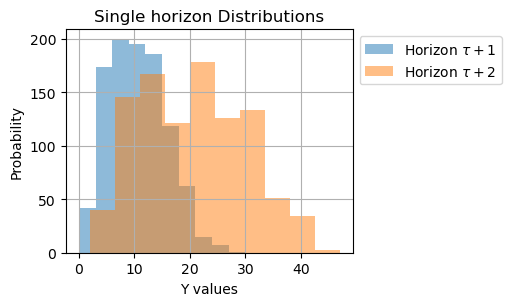

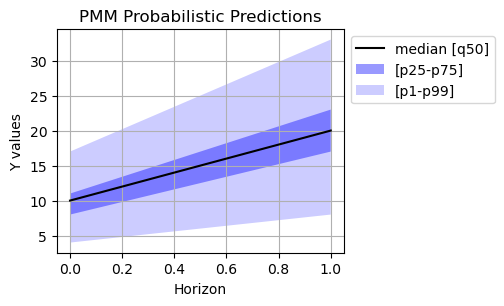

In [57]:
#| hide
# Create single mixture and broadcast to N,H,K
weights = torch.ones((1,3))[None, :, :]
lambdas = torch.Tensor([[5,10,15], [10,20,30]])[None, :, :]

# Create repetitions for the batch dimension N.
N=2
weights = torch.repeat_interleave(input=weights, repeats=N, dim=0)
lambdas = torch.repeat_interleave(input=lambdas, repeats=N, dim=0)

print('weights.shape (N,H,K) \t', weights.shape)
print('lambdas.shape (N,H,K) \t', lambdas.shape)

distr = PMM(quantiles=[0.1, 0.40, 0.5, 0.60, 0.9])
distr_args = (lambdas,)
samples, sample_mean, quants = distr.sample(distr_args)

print('samples.shape (N,H,num_samples) ', samples.shape)
print('sample_mean.shape (N,H) ', sample_mean.shape)
print('quants.shape  (N,H,Q) \t\t', quants.shape)

# Plot synthethic data
x_plot = range(quants.shape[1]) # H length
y_plot_hat = quants[0,:,:]  # Filter N,G,T -> H,Q
samples_hat = samples[0,:,:]  # Filter N,G,T -> H,num_samples

# Kernel density plot for single forecast horizon \tau = t+1
fig, ax = plt.subplots(figsize=(3.7, 2.9))

ax.hist(samples_hat[0,:], alpha=0.5, label=r'Horizon $\tau+1$')
ax.hist(samples_hat[1,:], alpha=0.5, label=r'Horizon $\tau+2$')
ax.set(xlabel='Y values', ylabel='Probability')
plt.title('Single horizon Distributions')
plt.legend(bbox_to_anchor=(1, 1), loc='upper left', ncol=1)
plt.grid()
plt.show()
plt.close()

# Plot simulated trajectory
fig, ax = plt.subplots(figsize=(3.7, 2.9))
plt.plot(x_plot, y_plot_hat[:,2], color='black', label='median [q50]')
plt.fill_between(x_plot,
                 y1=y_plot_hat[:,1], y2=y_plot_hat[:,3],
                 facecolor='blue', alpha=0.4, label='[p25-p75]')
plt.fill_between(x_plot,
                 y1=y_plot_hat[:,0], y2=y_plot_hat[:,4],
                 facecolor='blue', alpha=0.2, label='[p1-p99]')
ax.set(xlabel='Horizon', ylabel='Y values')
plt.title('PMM Probabilistic Predictions')
plt.legend(bbox_to_anchor=(1, 1), loc='upper left', ncol=1)
plt.grid()
plt.show()
plt.close()

## Gaussian Mixture Mesh (GMM)

In [58]:
#| export
class GMM(torch.nn.Module):
    """ Gaussian Mixture Mesh

    This Gaussian Mixture statistical model assumes independence across groups of 
    data $\mathcal{G}=\{[g_{i}]\}$, and estimates relationships within the group.

    $$ \mathrm{P}\\left(\mathbf{y}_{[b][t+1:t+H]}\\right) = 
    \prod_{ [g_{i}] \in \mathcal{G}} \mathrm{P}\left(\mathbf{y}_{[g_{i}][\\tau]}\\right)=
    \prod_{\\beta\in[g_{i}]}
    \\left(\sum_{k=1}^{K} w_k \prod_{(\\beta,\\tau) \in [g_i][t+1:t+H]} 
    \mathrm{Gaussian}(y_{\\beta,\\tau}, \hat{\mu}_{\\beta,\\tau,k}, \sigma_{\\beta,\\tau,k})\\right)$$

    **Parameters:**<br>
    `n_components`: int=10, the number of mixture components.<br>
    `level`: float list [0,100], confidence levels for prediction intervals.<br>
    `quantiles`: float list [0,1], alternative to level list, target quantiles.<br>
    `return_params`: bool=False, wether or not return the Distribution parameters.<br>
    `batch_correlation`: bool=False, wether or not model batch correlations.<br>
    `horizon_correlation`: bool=False, wether or not model horizon correlations.<br><br>

    **References:**<br>
    [Kin G. Olivares, O. Nganba Meetei, Ruijun Ma, Rohan Reddy, Mengfei Cao, Lee Dicker. 
    Probabilistic Hierarchical Forecasting with Deep Poisson Mixtures. Submitted to the International 
    Journal Forecasting, Working paper available at arxiv.](https://arxiv.org/pdf/2110.13179.pdf)
    """
    def __init__(self, n_components=1, level=[80, 90], quantiles=None, 
                 num_samples=1000, return_params=False,
                 batch_correlation=False, horizon_correlation=False):
        super(GMM, self).__init__()
        # Transform level to MQLoss parameters
        qs, self.output_names = level_to_outputs(level)
        qs = torch.Tensor(qs)

        # Transform quantiles to homogeneus output names
        if quantiles is not None:
            _, self.output_names = quantiles_to_outputs(quantiles)
            qs = torch.Tensor(quantiles)
        self.quantiles = torch.nn.Parameter(qs, requires_grad=False)
        self.num_samples = num_samples
        self.batch_correlation = batch_correlation
        self.horizon_correlation = horizon_correlation        

        # If True, predict_step will return Distribution's parameters
        self.return_params = return_params
        if self.return_params:
            mu_names = [f"-mu-{i}" for i in range(1, n_components + 1)]
            std_names = [f"-std-{i}" for i in range(1, n_components + 1)]
            mu_std_names = [i for j in zip(mu_names, std_names) for i in j]
            self.output_names = self.output_names + mu_std_names

        # Add first output entry for the sample_mean
        self.output_names.insert(0, "")

        self.outputsize_multiplier = 2 * n_components
        self.is_distribution_output = True

    def domain_map(self, output: torch.Tensor):
        means, stds = torch.tensor_split(output, 2, dim=-1)
        return (means, stds)

    def scale_decouple(self, 
                       output,
                       loc: Optional[torch.Tensor] = None,
                       scale: Optional[torch.Tensor] = None,
                       eps: float=0.2):
        """ Scale Decouple

        Stabilizes model's output optimization, by learning residual
        variance and residual location based on anchoring `loc`, `scale`.
        Also adds domain protection to the distribution parameters.
        """
        means, stds = output
        stds = F.softplus(stds)
        if (loc is not None) and (scale is not None):
            loc = loc.view(means.size(dim=0), 1, -1)
            scale = scale.view(means.size(dim=0), 1, -1)            
            means = (means * scale) + loc
            stds = (stds + eps) * scale
        return (means, stds)

    def sample(self, distr_args, num_samples=None):
        """
        Construct the empirical quantiles from the estimated Distribution,
        sampling from it `num_samples` independently.

        **Parameters**<br>
        `distr_args`: Constructor arguments for the underlying Distribution type.<br>
        `loc`: Optional tensor, of the same shape as the batch_shape + event_shape
               of the resulting distribution.<br>
        `scale`: Optional tensor, of the same shape as the batch_shape+event_shape 
               of the resulting distribution.<br>
        `num_samples`: int=500, number of samples for the empirical quantiles.<br>

        **Returns**<br>
        `samples`: tensor, shape [B,H,`num_samples`].<br>
        `quantiles`: tensor, empirical quantiles defined by `levels`.<br>
        """
        if num_samples is None:
            num_samples = self.num_samples
            
        means, stds = distr_args
        B, H, K = means.size()
        Q = len(self.quantiles)
        assert means.shape == stds.shape

        # Sample K ~ Mult(weights)
        # shared across B, H
        # weights = torch.repeat_interleave(input=weights, repeats=H, dim=2)
        
        weights = (1/K) * torch.ones_like(means).to(means.device)
        
        # Avoid loop, vectorize
        weights = weights.reshape(-1, K)
        means = means.flatten()
        stds = stds.flatten()

        # Vectorization trick to recover row_idx
        sample_idxs = torch.multinomial(input=weights, 
                                        num_samples=num_samples,
                                        replacement=True)
        aux_col_idx = torch.unsqueeze(torch.arange(B*H),-1) * K

        # To device
        sample_idxs = sample_idxs.to(means.device)
        aux_col_idx = aux_col_idx.to(means.device)

        sample_idxs = sample_idxs + aux_col_idx
        sample_idxs = sample_idxs.flatten()

        sample_means = means[sample_idxs]
        sample_stds  = stds[sample_idxs]

        # Sample y ~ Normal(mu, std) independently
        samples = torch.normal(sample_means, sample_stds).to(means.device)
        samples = samples.view(B*H, num_samples)
        sample_mean = torch.mean(samples, dim=-1)

        # Compute quantiles
        quantiles_device = self.quantiles.to(means.device)
        quants = torch.quantile(input=samples, q=quantiles_device, dim=1)
        quants = quants.permute((1,0)) # Q, B*H

        # Final reshapes
        samples = samples.view(B, H, num_samples)
        sample_mean = sample_mean.view(B, H, 1)
        quants  = quants.view(B, H, Q)

        return samples, sample_mean, quants

    def neglog_likelihood(self,
                          y: torch.Tensor,
                          distr_args: Tuple[torch.Tensor, torch.Tensor],
                          mask: Union[torch.Tensor, None] = None):

        if mask is None: 
            mask = torch.ones_like(y)
            
        means, stds = distr_args
        B, H, K = means.size()
        
        weights = (1/K) * torch.ones_like(means).to(means.device)
        
        y = y[:,:, None]
        mask = mask[:,:,None]
        
        var = stds ** 2
        log_stds = torch.log(stds)
        log_pi = - ((y - means) ** 2 / (2 * var)) - log_stds \
                 - math.log(math.sqrt(2 * math.pi))

        if self.batch_correlation:
            log_pi  = torch.sum(log_pi, dim=0, keepdim=True)

        if self.horizon_correlation:    
            log_pi  = torch.sum(log_pi, dim=1, keepdim=True)

        # Numerically Stable Mixture loglikelihood
        loglik = torch.logsumexp((torch.log(weights) + log_pi), dim=2, keepdim=True)
        loglik  = loglik * mask

        loss = -torch.mean(loglik)
        return loss
    
    def __call__(self, y: torch.Tensor,
                 distr_args: Tuple[torch.Tensor, torch.Tensor],
                 mask: Union[torch.Tensor, None] = None,):

        return self.neglog_likelihood(y=y, distr_args=distr_args, mask=mask)

In [59]:
show_doc(GMM, name='GMM.__init__', title_level=3)

---

[source](https://github.com/Nixtla/neuralforecast/blob/main/neuralforecast/losses/pytorch.py#L1450){target="_blank" style="float:right; font-size:smaller"}

### GMM.__init__

>      GMM.__init__ (n_components=1, level=[80, 90], quantiles=None,
>                    num_samples=1000, return_params=False,
>                    batch_correlation=False, horizon_correlation=False)

Gaussian Mixture Mesh

This Gaussian Mixture statistical model assumes independence across groups of 
data $\mathcal{G}=\{[g_{i}]\}$, and estimates relationships within the group.

$$ \mathrm{P}\left(\mathbf{y}_{[b][t+1:t+H]}\right) = 
\prod_{ [g_{i}] \in \mathcal{G}} \mathrm{P}\left(\mathbf{y}_{[g_{i}][\tau]}\right)=
\prod_{\beta\in[g_{i}]}
\left(\sum_{k=1}^{K} w_k \prod_{(\beta,\tau) \in [g_i][t+1:t+H]} 
\mathrm{Gaussian}(y_{\beta,\tau}, \hat{\mu}_{\beta,\tau,k}, \sigma_{\beta,\tau,k})\right)$$

**Parameters:**<br>
`n_components`: int=10, the number of mixture components.<br>
`level`: float list [0,100], confidence levels for prediction intervals.<br>
`quantiles`: float list [0,1], alternative to level list, target quantiles.<br>
`return_params`: bool=False, wether or not return the Distribution parameters.<br>
`batch_correlation`: bool=False, wether or not model batch correlations.<br>
`horizon_correlation`: bool=False, wether or not model horizon correlations.<br><br>

**References:**<br>
[Kin G. Olivares, O. Nganba Meetei, Ruijun Ma, Rohan Reddy, Mengfei Cao, Lee Dicker. 
Probabilistic Hierarchical Forecasting with Deep Poisson Mixtures. Submitted to the International 
Journal Forecasting, Working paper available at arxiv.](https://arxiv.org/pdf/2110.13179.pdf)

In [60]:
show_doc(GMM.sample, name='GMM.sample', title_level=3)

---

[source](https://github.com/Nixtla/neuralforecast/blob/main/neuralforecast/losses/pytorch.py#L1537){target="_blank" style="float:right; font-size:smaller"}

### GMM.sample

>      GMM.sample (distr_args, num_samples=None)

Construct the empirical quantiles from the estimated Distribution,
sampling from it `num_samples` independently.

**Parameters**<br>
`distr_args`: Constructor arguments for the underlying Distribution type.<br>
`loc`: Optional tensor, of the same shape as the batch_shape + event_shape
       of the resulting distribution.<br>
`scale`: Optional tensor, of the same shape as the batch_shape+event_shape 
       of the resulting distribution.<br>
`num_samples`: int=500, number of samples for the empirical quantiles.<br>

**Returns**<br>
`samples`: tensor, shape [B,H,`num_samples`].<br>
`quantiles`: tensor, empirical quantiles defined by `levels`.<br>

In [61]:
show_doc(GMM.__call__, name='GMM.__call__', title_level=3)

---

[source](https://github.com/Nixtla/neuralforecast/blob/main/neuralforecast/losses/pytorch.py#L1642){target="_blank" style="float:right; font-size:smaller"}

### GMM.__call__

>      GMM.__call__ (y:torch.Tensor,
>                    distr_args:Tuple[torch.Tensor,torch.Tensor],
>                    mask:Union[torch.Tensor,NoneType]=None)

Call self as a function.

![](imgs_losses/gmm.png)

In [62]:
# | hide
# Unit tests to check PMM's stored quantiles
# attribute is correctly instantiated
check = GMM(n_components=2, level=[80, 90])
test_eq(len(check.quantiles), 5)

check = GMM(n_components=2, 
            quantiles=[0.0100, 0.1000, 0.5, 0.9000, 0.9900])
print(check.output_names)
print(check.quantiles)
test_eq(len(check.quantiles), 5)

check = GMM(n_components=2,
            quantiles=[0.0100, 0.1000, 0.9000, 0.9900])
test_eq(len(check.quantiles), 4)

['', '-lo-98.0', '-lo-80.0', '-median', '-hi-80.0', '-hi-98.0']
Parameter containing:
tensor([0.0100, 0.1000, 0.5000, 0.9000, 0.9900])


weights.shape (N,H,K) 	 torch.Size([2, 2, 3])
means.shape (N,H,K) 	 torch.Size([2, 2, 3])
stds.shape (N,H,K) 	 torch.Size([2, 2, 3])
samples.shape (N,H,num_samples)  torch.Size([2, 2, 1000])
sample_mean.shape (N,H)  torch.Size([2, 2, 1])
quants.shape  (N,H,Q) 		 torch.Size([2, 2, 5])


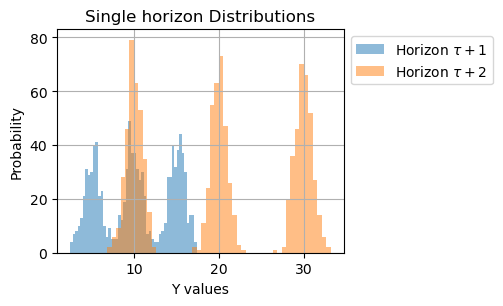

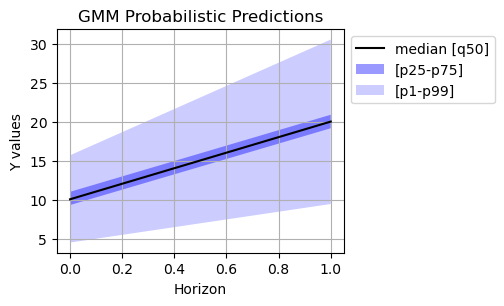

In [63]:
#| hide
# Create single mixture and broadcast to N,H,K
means   = torch.Tensor([[5,10,15], [10,20,30]])[None, :, :]

# # Create repetitions for the batch dimension N.
N=2
means = torch.repeat_interleave(input=means, repeats=N, dim=0)
weights = torch.ones_like(means)
stds  = torch.ones_like(means)

print('weights.shape (N,H,K) \t', weights.shape)
print('means.shape (N,H,K) \t', means.shape)
print('stds.shape (N,H,K) \t', stds.shape)

distr = GMM(quantiles=[0.1, 0.40, 0.5, 0.60, 0.9])
distr_args = (means, stds)
samples, sample_mean, quants = distr.sample(distr_args)

print('samples.shape (N,H,num_samples) ', samples.shape)
print('sample_mean.shape (N,H) ', sample_mean.shape)
print('quants.shape  (N,H,Q) \t\t', quants.shape)

# Plot synthethic data
x_plot = range(quants.shape[1]) # H length
y_plot_hat = quants[0,:,:]  # Filter N,G,T -> H,Q
samples_hat = samples[0,:,:]  # Filter N,G,T -> H,num_samples

# Kernel density plot for single forecast horizon \tau = t+1
fig, ax = plt.subplots(figsize=(3.7, 2.9))

ax.hist(samples_hat[0,:], alpha=0.5, bins=50,
        label=r'Horizon $\tau+1$')
ax.hist(samples_hat[1,:], alpha=0.5, bins=50,
        label=r'Horizon $\tau+2$')
ax.set(xlabel='Y values', ylabel='Probability')
plt.title('Single horizon Distributions')
plt.legend(bbox_to_anchor=(1, 1), loc='upper left', ncol=1)
plt.grid()
plt.show()
plt.close()

# Plot simulated trajectory
fig, ax = plt.subplots(figsize=(3.7, 2.9))
plt.plot(x_plot, y_plot_hat[:,2], color='black', label='median [q50]')
plt.fill_between(x_plot,
                 y1=y_plot_hat[:,1], y2=y_plot_hat[:,3],
                 facecolor='blue', alpha=0.4, label='[p25-p75]')
plt.fill_between(x_plot,
                 y1=y_plot_hat[:,0], y2=y_plot_hat[:,4],
                 facecolor='blue', alpha=0.2, label='[p1-p99]')
ax.set(xlabel='Horizon', ylabel='Y values')
plt.title('GMM Probabilistic Predictions')
plt.legend(bbox_to_anchor=(1, 1), loc='upper left', ncol=1)
plt.grid()
plt.show()
plt.close()

## Negative Binomial Mixture Mesh (NBMM)

In [64]:
#| export
class NBMM(torch.nn.Module):
    """ Negative Binomial Mixture Mesh

    This N. Binomial Mixture statistical model assumes independence across groups of 
    data $\mathcal{G}=\{[g_{i}]\}$, and estimates relationships within the group.

    $$ \mathrm{P}\\left(\mathbf{y}_{[b][t+1:t+H]}\\right) = 
    \prod_{ [g_{i}] \in \mathcal{G}} \mathrm{P}\left(\mathbf{y}_{[g_{i}][\\tau]}\\right)=
    \prod_{\\beta\in[g_{i}]}
    \\left(\sum_{k=1}^{K} w_k \prod_{(\\beta,\\tau) \in [g_i][t+1:t+H]} 
    \mathrm{NBinomial}(y_{\\beta,\\tau}, \hat{r}_{\\beta,\\tau,k}, \hat{p}_{\\beta,\\tau,k})\\right)$$

    **Parameters:**<br>
    `n_components`: int=10, the number of mixture components.<br>
    `level`: float list [0,100], confidence levels for prediction intervals.<br>
    `quantiles`: float list [0,1], alternative to level list, target quantiles.<br>
    `return_params`: bool=False, wether or not return the Distribution parameters.<br><br>

    **References:**<br>
    [Kin G. Olivares, O. Nganba Meetei, Ruijun Ma, Rohan Reddy, Mengfei Cao, Lee Dicker. 
    Probabilistic Hierarchical Forecasting with Deep Poisson Mixtures. Submitted to the International 
    Journal Forecasting, Working paper available at arxiv.](https://arxiv.org/pdf/2110.13179.pdf)
    """
    def __init__(self, n_components=1, level=[80, 90], quantiles=None, 
                 num_samples=1000, return_params=False):
        super(NBMM, self).__init__()
        # Transform level to MQLoss parameters
        qs, self.output_names = level_to_outputs(level)
        qs = torch.Tensor(qs)

        # Transform quantiles to homogeneus output names
        if quantiles is not None:
            _, self.output_names = quantiles_to_outputs(quantiles)
            qs = torch.Tensor(quantiles)
        self.quantiles = torch.nn.Parameter(qs, requires_grad=False)
        self.num_samples = num_samples

        # If True, predict_step will return Distribution's parameters
        self.return_params = return_params
        if self.return_params:
            total_count_names = [f"-total_count-{i}" for i in range(1, n_components + 1)]
            probs_names = [f"-probs-{i}" for i in range(1, n_components + 1)]
            param_names = [i for j in zip(total_count_names, probs_names) for i in j]
            self.output_names = self.output_names + param_names

        # Add first output entry for the sample_mean
        self.output_names.insert(0, "")            

        self.outputsize_multiplier = 2 * n_components
        self.is_distribution_output = True

    def domain_map(self, output: torch.Tensor):
        mu, alpha = torch.tensor_split(output, 2, dim=-1)
        return (mu, alpha)

    def scale_decouple(self, 
                       output,
                       loc: Optional[torch.Tensor] = None,
                       scale: Optional[torch.Tensor] = None,
                       eps: float=0.2):
        """ Scale Decouple

        Stabilizes model's output optimization, by learning residual
        variance and residual location based on anchoring `loc`, `scale`.
        Also adds domain protection to the distribution parameters.
        """
        # Efficient NBinomial parametrization
        mu, alpha = output
        mu = F.softplus(mu) + 1e-8
        alpha = F.softplus(alpha) + 1e-8    # alpha = 1/total_counts
        if (loc is not None) and (scale is not None):
            loc = loc.view(mu.size(dim=0), 1, -1)
            mu *= loc
            alpha /= (loc + 1.)

        # mu = total_count * (probs/(1-probs))
        # => probs = mu / (total_count + mu)
        # => probs = mu / [total_count * (1 + mu * (1/total_count))]
        total_count = 1.0 / alpha
        probs = (mu * alpha / (1.0 + mu * alpha)) + 1e-8 
        return (total_count, probs)

    def sample(self, distr_args, num_samples=None):
        """
        Construct the empirical quantiles from the estimated Distribution,
        sampling from it `num_samples` independently.

        **Parameters**<br>
        `distr_args`: Constructor arguments for the underlying Distribution type.<br>
        `loc`: Optional tensor, of the same shape as the batch_shape + event_shape
               of the resulting distribution.<br>
        `scale`: Optional tensor, of the same shape as the batch_shape+event_shape 
               of the resulting distribution.<br>
        `num_samples`: int=500, number of samples for the empirical quantiles.<br>

        **Returns**<br>
        `samples`: tensor, shape [B,H,`num_samples`].<br>
        `quantiles`: tensor, empirical quantiles defined by `levels`.<br>
        """
        if num_samples is None:
            num_samples = self.num_samples
            
        total_count, probs = distr_args
        B, H, K = total_count.size()
        Q = len(self.quantiles)
        assert total_count.shape == probs.shape

        # Sample K ~ Mult(weights)
        # shared across B, H
        # weights = torch.repeat_interleave(input=weights, repeats=H, dim=2)
        
        weights = (1/K) * torch.ones_like(probs).to(probs.device)
        
        # Avoid loop, vectorize
        weights = weights.reshape(-1, K)
        total_count = total_count.flatten()
        probs = probs.flatten()

        # Vectorization trick to recover row_idx
        sample_idxs = torch.multinomial(input=weights, 
                                        num_samples=num_samples,
                                        replacement=True)
        aux_col_idx = torch.unsqueeze(torch.arange(B*H),-1) * K

        # To device
        sample_idxs = sample_idxs.to(probs.device)
        aux_col_idx = aux_col_idx.to(probs.device)

        sample_idxs = sample_idxs + aux_col_idx
        sample_idxs = sample_idxs.flatten()

        sample_total_count = total_count[sample_idxs]
        sample_probs  = probs[sample_idxs]

        # Sample y ~ NBinomial(total_count, probs) independently
        dist = NegativeBinomial(total_count=sample_total_count, 
                                probs=sample_probs)
        samples = dist.sample(sample_shape=(1,)).to(probs.device)[0]
        samples = samples.view(B*H, num_samples)
        sample_mean = torch.mean(samples, dim=-1)

        # Compute quantiles
        quantiles_device = self.quantiles.to(probs.device)
        quants = torch.quantile(input=samples, q=quantiles_device, dim=1)
        quants = quants.permute((1,0)) # Q, B*H

        # Final reshapes
        samples = samples.view(B, H, num_samples)
        sample_mean = sample_mean.view(B, H, 1)
        quants  = quants.view(B, H, Q)

        return samples, sample_mean, quants

    def neglog_likelihood(self,
                          y: torch.Tensor,
                          distr_args: Tuple[torch.Tensor, torch.Tensor],
                          mask: Union[torch.Tensor, None] = None):

        if mask is None: 
            mask = torch.ones_like(y)
            
        total_count, probs = distr_args
        B, H, K = total_count.size()
        
        weights = (1/K) * torch.ones_like(probs).to(probs.device)
        
        y = y[:,:, None]
        mask = mask[:,:,None]

        log_unnormalized_prob = (total_count * torch.log(1.-probs) + y * torch.log(probs))
        log_normalization = (-torch.lgamma(total_count + y) + torch.lgamma(1. + y) +
                             torch.lgamma(total_count))
        log_normalization[total_count + y == 0.] = 0.
        log =  log_unnormalized_prob - log_normalization

        #log  = torch.sum(log, dim=0, keepdim=True) # Joint within batch/group
        #log  = torch.sum(log, dim=1, keepdim=True) # Joint within horizon

        # Numerical stability mixture and loglik
        log_max = torch.amax(log, dim=2, keepdim=True) # [1,1,K] (collapsed joints)
        lik     = weights * torch.exp(log-log_max)     # Take max
        loglik  = torch.log(torch.sum(lik, dim=2, keepdim=True)) + log_max # Return max
        
        loglik  = loglik * mask #replace with mask

        loss = -torch.mean(loglik)
        return loss
    
    def __call__(self, y: torch.Tensor,
                 distr_args: Tuple[torch.Tensor, torch.Tensor],
                 mask: Union[torch.Tensor, None] = None,):

        return self.neglog_likelihood(y=y, distr_args=distr_args, mask=mask)

In [65]:
show_doc(NBMM, name='NBMM.__init__', title_level=3)

---

[source](https://github.com/Nixtla/neuralforecast/blob/main/neuralforecast/losses/pytorch.py#L1651){target="_blank" style="float:right; font-size:smaller"}

### NBMM.__init__

>      NBMM.__init__ (n_components=1, level=[80, 90], quantiles=None,
>                     num_samples=1000, return_params=False)

Negative Binomial Mixture Mesh

This N. Binomial Mixture statistical model assumes independence across groups of 
data $\mathcal{G}=\{[g_{i}]\}$, and estimates relationships within the group.

$$ \mathrm{P}\left(\mathbf{y}_{[b][t+1:t+H]}\right) = 
\prod_{ [g_{i}] \in \mathcal{G}} \mathrm{P}\left(\mathbf{y}_{[g_{i}][\tau]}\right)=
\prod_{\beta\in[g_{i}]}
\left(\sum_{k=1}^{K} w_k \prod_{(\beta,\tau) \in [g_i][t+1:t+H]} 
\mathrm{NBinomial}(y_{\beta,\tau}, \hat{r}_{\beta,\tau,k}, \hat{p}_{\beta,\tau,k})\right)$$

**Parameters:**<br>
`n_components`: int=10, the number of mixture components.<br>
`level`: float list [0,100], confidence levels for prediction intervals.<br>
`quantiles`: float list [0,1], alternative to level list, target quantiles.<br>
`return_params`: bool=False, wether or not return the Distribution parameters.<br><br>

**References:**<br>
[Kin G. Olivares, O. Nganba Meetei, Ruijun Ma, Rohan Reddy, Mengfei Cao, Lee Dicker. 
Probabilistic Hierarchical Forecasting with Deep Poisson Mixtures. Submitted to the International 
Journal Forecasting, Working paper available at arxiv.](https://arxiv.org/pdf/2110.13179.pdf)

In [66]:
show_doc(NBMM.sample, name='NBMM.sample', title_level=3)

---

[source](https://github.com/Nixtla/neuralforecast/blob/main/neuralforecast/losses/pytorch.py#L1741){target="_blank" style="float:right; font-size:smaller"}

### NBMM.sample

>      NBMM.sample (distr_args, num_samples=None)

Construct the empirical quantiles from the estimated Distribution,
sampling from it `num_samples` independently.

**Parameters**<br>
`distr_args`: Constructor arguments for the underlying Distribution type.<br>
`loc`: Optional tensor, of the same shape as the batch_shape + event_shape
       of the resulting distribution.<br>
`scale`: Optional tensor, of the same shape as the batch_shape+event_shape 
       of the resulting distribution.<br>
`num_samples`: int=500, number of samples for the empirical quantiles.<br>

**Returns**<br>
`samples`: tensor, shape [B,H,`num_samples`].<br>
`quantiles`: tensor, empirical quantiles defined by `levels`.<br>

In [67]:
show_doc(NBMM.__call__, name='NBMM.__call__', title_level=3)

---

[source](https://github.com/Nixtla/neuralforecast/blob/main/neuralforecast/losses/pytorch.py#L1850){target="_blank" style="float:right; font-size:smaller"}

### NBMM.__call__

>      NBMM.__call__ (y:torch.Tensor,
>                     distr_args:Tuple[torch.Tensor,torch.Tensor],
>                     mask:Union[torch.Tensor,NoneType]=None)

Call self as a function.

weights.shape (N,H,K) 	 torch.Size([2, 2, 3])
counts.shape (N,H,K) 	 torch.Size([2, 2, 3])
probs.shape (N,H,K) 	 torch.Size([2, 2, 3])
samples.shape (N,H,num_samples)  torch.Size([2, 2, 2000])
sample_mean.shape (N,H)  torch.Size([2, 2, 1])
quants.shape  (N,H,Q) 		 torch.Size([2, 2, 5])


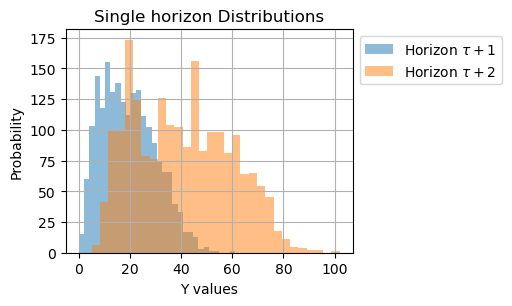

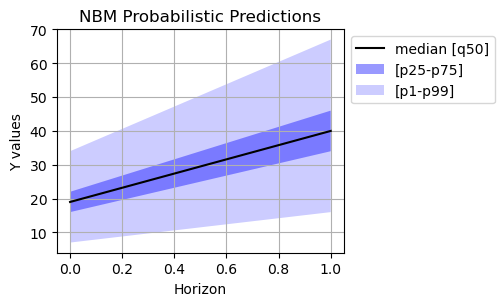

In [68]:
#| hide
# Create single mixture and broadcast to N,H,K
counts   = torch.Tensor([[10,20,30], [20,40,60]])[None, :, :]

# # Create repetitions for the batch dimension N.
N=2
counts = torch.repeat_interleave(input=counts, repeats=N, dim=0)
weights = torch.ones_like(counts)
probs  = torch.ones_like(counts) * 0.5

print('weights.shape (N,H,K) \t', weights.shape)
print('counts.shape (N,H,K) \t', counts.shape)
print('probs.shape (N,H,K) \t', probs.shape)

model = NBMM(quantiles=[0.1, 0.40, 0.5, 0.60, 0.9])
distr_args = (counts, probs)
samples, sample_mean, quants = model.sample(distr_args, num_samples=2000)

print('samples.shape (N,H,num_samples) ', samples.shape)
print('sample_mean.shape (N,H) ', sample_mean.shape)
print('quants.shape  (N,H,Q) \t\t', quants.shape)

# Plot synthethic data
x_plot = range(quants.shape[1]) # H length
y_plot_hat = quants[0,:,:]  # Filter N,G,T -> H,Q
samples_hat = samples[0,:,:]  # Filter N,G,T -> H,num_samples

# Kernel density plot for single forecast horizon \tau = t+1
fig, ax = plt.subplots(figsize=(3.7, 2.9))

ax.hist(samples_hat[0,:], alpha=0.5, bins=30,
        label=r'Horizon $\tau+1$')
ax.hist(samples_hat[1,:], alpha=0.5, bins=30,
        label=r'Horizon $\tau+2$')
ax.set(xlabel='Y values', ylabel='Probability')
plt.title('Single horizon Distributions')
plt.legend(bbox_to_anchor=(1, 1), loc='upper left', ncol=1)
plt.grid()
plt.show()
plt.close()

# Plot simulated trajectory
fig, ax = plt.subplots(figsize=(3.7, 2.9))
plt.plot(x_plot, y_plot_hat[:,2], color='black', label='median [q50]')
plt.fill_between(x_plot,
                 y1=y_plot_hat[:,1], y2=y_plot_hat[:,3],
                 facecolor='blue', alpha=0.4, label='[p25-p75]')
plt.fill_between(x_plot,
                 y1=y_plot_hat[:,0], y2=y_plot_hat[:,4],
                 facecolor='blue', alpha=0.2, label='[p1-p99]')
ax.set(xlabel='Horizon', ylabel='Y values')
plt.title('NBM Probabilistic Predictions')
plt.legend(bbox_to_anchor=(1, 1), loc='upper left', ncol=1)
plt.grid()
plt.show()
plt.close()